In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import distance_transform_edt, gaussian_filter
import bz2
import pickle
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import models_utils as mu
from sklearn.model_selection import train_test_split
import cv2
import time
from livelossplot import PlotLosses
import torchvision.transforms.functional as TF
import pandas as pd
from collections import Counter
import ASPP_utils as amu

Loading in the data 

In [3]:
df = pd.read_csv('final_dataset_filtered.csv') 

In [4]:
df.head()

img_path         xmin  \
0    Carlos Vera Guevara RGB_3_0_8305_4000_12305.png  3332.557861   
1    Carlos Vera Guevara RGB_3_0_8305_4000_12305.png  3162.579834   
2    Carlos Vera Guevara RGB_3_0_8305_4000_12305.png  2893.605713   
3    Carlos Vera Guevara RGB_3_0_8305_4000_12305.png  2595.111084   
4  Carlos Vera Guevara RGB_10_7600_7600_11600_116...   249.691879   

          ymin         xmax         ymax     score                 img_name  \
0    19.092411  3661.390137   364.616425  0.531211  Carlos Vera Guevara RGB   
1  2148.233398  3431.632324  2379.467041  0.511510  Carlos Vera Guevara RGB   
2   244.011108  3095.620605   451.257812  0.251310  Carlos Vera Guevara RGB   
3  1703.712402  2765.227295  1865.253418  0.217742  Carlos Vera Guevara RGB   
4   123.626862   439.557648   302.768402  0.282849  Carlos Vera Guevara RGB   

   tile_index  tile_xmin  tile_ymin  ...                     site  \
0           3          0       8305  ...  Carlos Vera Guevara RGB   
1           3          0       8305  ...  Carlos Vera Guevara RGB   
2           3          0       8305  ...  Carlos Vera Guevara RGB   
3           3          0       8305  ...  Carlos Vera Guevara RGB   
4          10       7600       7600  ...  Carlos Vera Guevara RGB   

           X_g          Y_g  updated diameter   group  updated height  \
0  5298.555843  7709.844671         10.281385  banana             0.0   
1  5315.345160  8606.745732         13.528139  banana             0.0   
2  5228.142461  7935.770200         12.732366  banana             0.0   
3  4434.058601  8354.081799          9.867583  banana             0.0   
4  8257.952942  7554.538338         17.825312  banana             0.0   

         AGB    carbon   id  unique_id  
0   4.293300  1.674387   30          1  
1   7.702971  3.004159  112          2  
2   6.769828  2.640233  179          3  
3   3.933601  1.534104   93          4  
4  13.862143  5.406236  162          5  

[5 rows x 44 columns]

In [5]:
df.shape

(2602, 44)

## Background Details for Class Weighting 

In [6]:
df['name'].value_counts()

name
Musacea               1471
Guaba                  523
Cacao                  233
Mango                   83
Otra variedad           80
Variedad bifurcada      71
Roble                   25
Melina                  16
Fernan Sanchez          16
Pachaco                 13
Guanabana               12
Caoba                   11
Guayacan                 8
Laurel                   6
Guachapeli               6
Achotillo                5
Sapote                   5
Yafruit                  5
Cedro                    4
Teca                     4
Naranja                  2
Fruta de Pan             1
Mandarina                1
MaraÃ±on                 1
Name: count, dtype: int64

In [7]:
#combining everything under 80 to 'other'
df['name'] = df['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')

In [8]:
df['name'].value_counts()

name
Musacea          1471
Guaba             523
Otra variedad     292
Cacao             233
Mango              83
Name: count, dtype: int64

In [9]:
species_counts = {
    'Musacea': 1471,
    'Guaba': 523,
    'Otra variedad': 292,
    'Cacao': 233,
    'Mango': 83
}

In [10]:
df['name'].value_counts(normalize=True)

name
Musacea          0.565334
Guaba            0.200999
Otra variedad    0.112221
Cacao            0.089547
Mango            0.031899
Name: proportion, dtype: float64

## Discarding boxes that overlap too much 

In [10]:
def compute_iou(box1, box2):
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    xi1 = max(x_min1, x_min2)
    yi1 = max(y_min1, y_min2)
    xi2 = min(x_max1, x_max2)
    yi2 = min(y_max1, y_max2)

    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    box1_area = (x_max1 - x_min1 + 1) * (y_max1 - y_min1 + 1)
    box2_area = (x_max2 - x_min2 + 1) * (y_max2 - y_min2 + 1)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou


In [11]:

def discard_overlapping_boxes(df, species_counts, iou_threshold=0.7): 
    indices_to_discard = set()
    count = 0
    for i, box1 in df.iterrows():
        if i in indices_to_discard:
            continue
        for j, box2 in df.iterrows():
            if i >= j or j in indices_to_discard:
                continue
            iou = compute_iou(
                (box1['xmin'], box1['ymin'], box1['xmax'], box1['ymax']),
                (box2['xmin'], box2['ymin'], box2['xmax'], box2['ymax'])
            )
            if iou > iou_threshold:
                species1_count = species_counts[box1['name']]
                species2_count = species_counts[box2['name']]
                if species1_count > species2_count:
                    indices_to_discard.add(i)
                    count += 1
                    print(f"{count}. Discarded box {i} from tile {box1['img_path']} (Species: {box1['name']}) - More common species")
                    break  # No need to check further for this box
                elif species2_count > species1_count:
                    indices_to_discard.add(j)
                    count += 1
                    print(f"{count}. Discarded box {j} from tile {box2['img_path']} (Species: {box2['name']}) - More common species")
                else:
                    # If counts are equal, discard the one with the higher index (or use another criterion)
                    indices_to_discard.add(j)
                    count += 1
                    print(f"{count}. Discarded box {j} from tile {box2['img_path']} (Species: {box2['name']}) due to equal species count")

    df_cleaned = df.drop(indices_to_discard).reset_index(drop=True)
    return df_cleaned, indices_to_discard

In [12]:
#df_cleaned, discarded_boxes = discard_overlapping_boxes(df, species_counts, iou_threshold=0.7)

In [13]:
#saving and loading the cleaned dataset and the indices of the discarded boxes so I don't have to run the code every time
df_cleaned = pd.read_csv('final_dataset_filtered_cleaned.csv')
with open('discarded_boxes.pkl', 'rb') as f:
    discarded_boxes = pickle.load(f)

In [14]:
df_cleaned['name'].value_counts()

name
Musacea          1192
Guaba             403
Otra variedad     264
Cacao             228
Mango              79
Name: count, dtype: int64

In [15]:
print(f"Discarded {len(discarded_boxes)} boxes")
print(f"Remaining boxes: {len(df_cleaned)}")
print(f"Original boxes: {len(df)}")

Discarded 436 boxes
Remaining boxes: 2166
Original boxes: 2602


In [16]:
def draw_bounding_boxes(image_path, bounding_boxes, color = (255, 0, 0), thickness = 20):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image at {image_path} could not be loaded.")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw each bounding box
    for bbox in bounding_boxes:
        xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
        cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 20)
    
    return image

In [17]:
def visualize_discarded_and_cleaned(df, df_cleaned, indices_to_discard, image_name):
    # Get bounding boxes for the original data
    first_group_original = df[df['img_path'] == image_name]
    bounding_boxes_original = first_group_original[['xmin', 'ymin', 'xmax', 'ymax']].to_dict('records')
    print(f"Original bounding boxes: {len(bounding_boxes_original)}")

    # Get bounding boxes for the cleaned data
    first_group_cleaned = df_cleaned[df_cleaned['img_path'] == image_name]
    bounding_boxes_cleaned = first_group_cleaned[['xmin', 'ymin', 'xmax', 'ymax']].to_dict('records')
    print(f"Cleaned bounding boxes: {len(bounding_boxes_cleaned)}")

    # Get bounding boxes to be removed
    discarded_boxes_filtered = df.iloc[list(indices_to_discard)]
    discarded_boxes_filtered = discarded_boxes_filtered[discarded_boxes_filtered['img_path'] == image_name]
    bounding_boxes_discarded = discarded_boxes_filtered[['xmin', 'ymin', 'xmax', 'ymax']].to_dict('records')
    print(f"Discarded bounding boxes: {len(bounding_boxes_discarded)}")

    # Construct the full image path
    image_path_full = 'data/tiles/processed/' + image_name

    # Draw bounding boxes on the original image
    annotated_image_original = draw_bounding_boxes(image_path_full, bounding_boxes_original, color=(255, 0, 0))

    # Draw bounding boxes with discarded boxes in a different color (green)
    annotated_image_highlighted = draw_bounding_boxes(image_path_full, bounding_boxes_discarded, color=(0, 255, 0))

    # Draw bounding boxes on the cleaned image
    annotated_image_cleaned = draw_bounding_boxes(image_path_full, bounding_boxes_cleaned, color=(255, 0, 0))

    # Display the images side by side
    if annotated_image_original is not None and annotated_image_highlighted is not None and annotated_image_cleaned is not None:
        fig, axes = plt.subplots(1, 3, figsize=(30, 10))

        axes[0].imshow(annotated_image_original)
        axes[0].set_title(f"Original Image: {image_path_full}")
        axes[0].axis('off')

        axes[1].imshow(annotated_image_highlighted)
        axes[1].set_title(f"Original Image with Boxes to be Removed: {image_path_full}")
        axes[1].axis('off')

        axes[2].imshow(annotated_image_cleaned)
        axes[2].set_title(f"Cleaned Image: {image_path_full}")
        axes[2].axis('off')

        plt.show()

Original bounding boxes: 70
Cleaned bounding boxes: 51
Discarded bounding boxes: 19


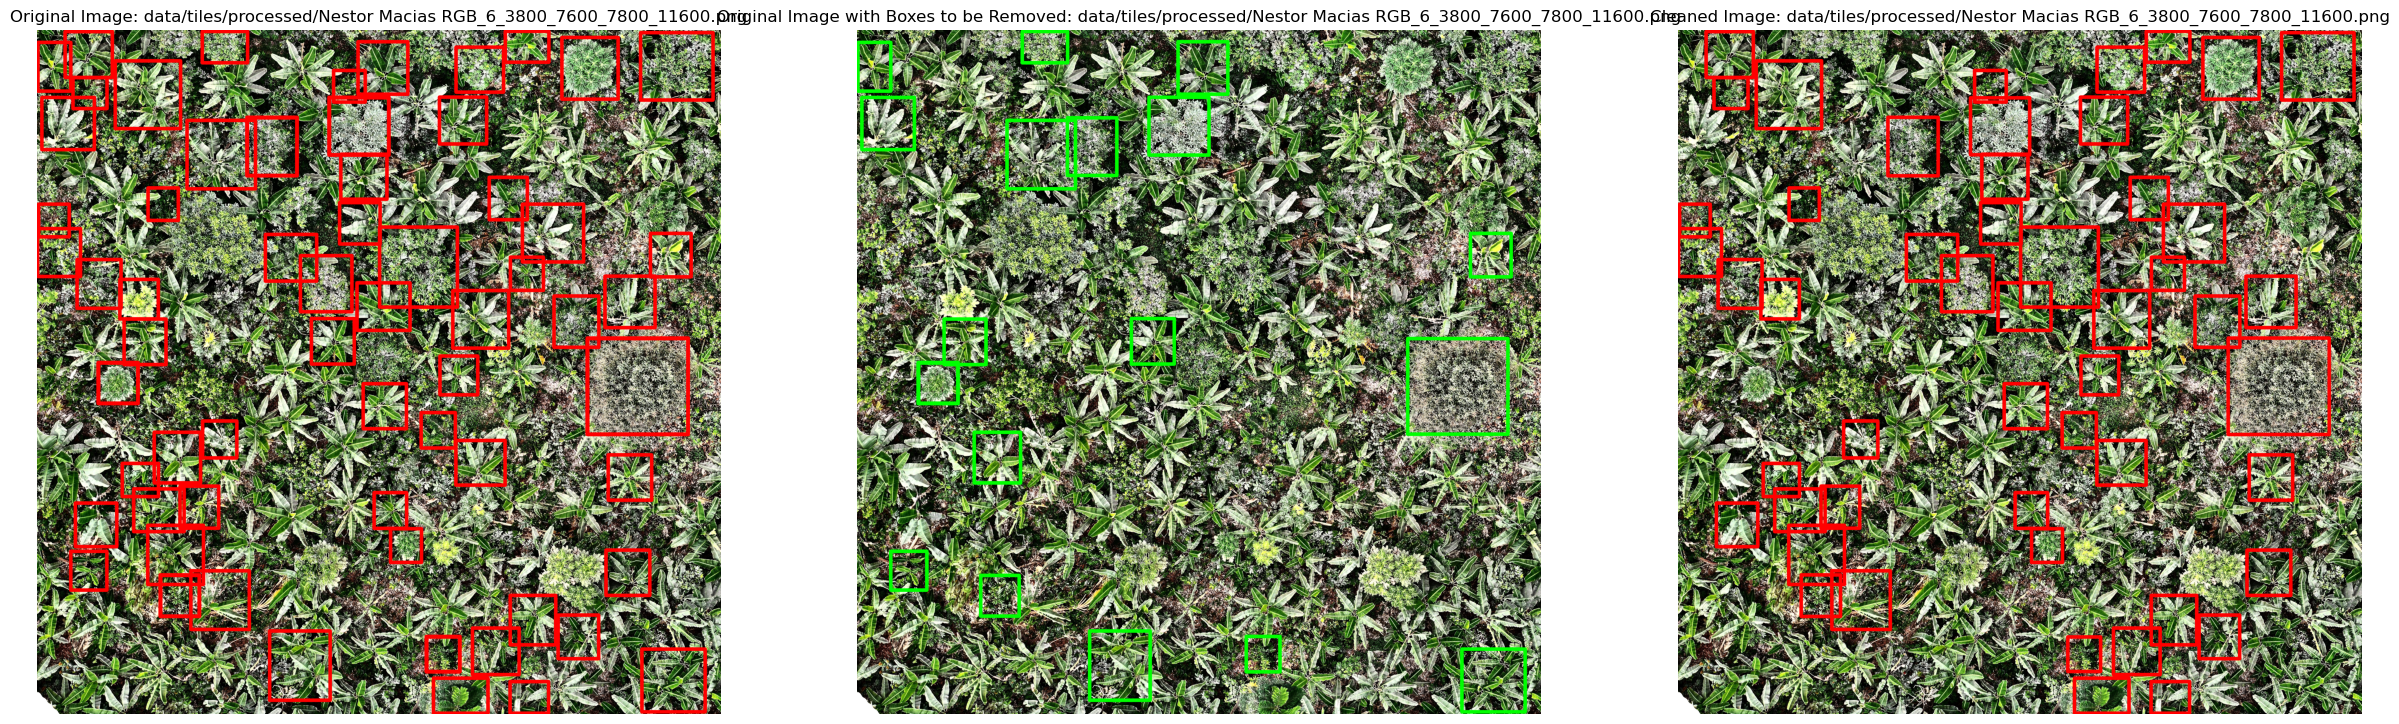

In [18]:
image_name = 'Nestor Macias RGB_6_3800_7600_7800_11600.png'
visualize_discarded_and_cleaned(df, df_cleaned, discarded_boxes, image_name)

**NB: This visualization doesn't look quite right, but I am confident the issue is in the visualization so only come back if I have time**

## Loading and Visualizing Data

In [19]:
transform = amu.RandomTransforms(
    horizontal_flip_prob=0.5,
    vertical_flip_prob=0.5,
    rotation_degrees=[0, 90, 180, 270]
)

### Splitting and Loading the Data

In [20]:
#smaller dataset for testing
df_small = df_cleaned.sample(100, random_state=42)

In [21]:
#show entire first row of df_small
df_small.iloc[1]

img_path            Carlos Vera Arteaga RGB_4_3800_0_7800_4000.png
xmin                                                   1651.265259
ymin                                                   3496.242432
xmax                                                   1836.424927
ymax                                                   3685.436523
score                                                      0.26781
img_name                                   Carlos Vera Arteaga RGB
tile_index                                                       4
tile_xmin                                                     3800
tile_ymin                                                        0
tile_xmax                                                     7800
tile_ymax                                                     4000
x                                                      1743.345093
y                                                      3590.339478
Xmin                                                   5451.26

In [22]:
unique_itcs = df_cleaned['unique_id'].unique()

In [23]:
train_itcs, test_itcs = train_test_split(unique_itcs, test_size=0.4, random_state=42)

In [24]:
train_df = df_cleaned[df_cleaned['unique_id'].isin(train_itcs)]
test_df = df_cleaned[df_cleaned['unique_id'].isin(test_itcs)]

In [25]:
train_itcs, val_itcs = train_test_split(train_itcs, test_size=0.1, random_state=42)
val_df = df_cleaned[df_cleaned['unique_id'].isin(val_itcs)]

In [26]:
print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Testing set size: {len(test_df)}')

Training set size: 1299
Validation set size: 130
Testing set size: 867


In [27]:
root_dir = 'data/tiles/processed'

In [28]:
#test map generation 
image_name = 'Carlos Vera Guevara RGB_3_0_8305_4000_12305.png'
single_image_annotations = df[df['img_path'] == image_name]

In [29]:
img_path = os.path.join(root_dir, image_name)  # Adjust the path
img = Image.open(img_path)
image_size = img.size[::-1]

In [30]:
#this was just for testing; commenting out so it does not run every time 
#species_map, distance_map = mu.generate_combined_maps(single_image_annotations, image_size)

In [31]:
import matplotlib.pyplot as plt

def visualize_maps(species_map, distance_map):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Species Map')
    plt.imshow(species_map, cmap='viridis')  # Use a colormap that shows differences well
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Distance Map')
    plt.imshow(distance_map, cmap='plasma')  # Use a colormap that shows differences well
    plt.colorbar()
    plt.axis('off')
    
    plt.show()

# Call the visualization function

#commented out so this does not run every time
#visualize_maps(species_map, distance_map)


In [32]:
#smaller dataset for testing
df_small = df_cleaned.sample(200, random_state=42)
unique_itcs_small = df_small['unique_id'].unique()


In [33]:
unique_df_small = df_small.drop_duplicates(subset='unique_id')[['unique_id', 'name']]

In [34]:
train_itcs, test_itcs = train_test_split(
    unique_itcs_small, test_size=0.4, random_state=42, stratify=unique_df_small['name']
)
train_itcs, val_itcs = train_test_split(
    train_itcs, test_size=0.2, random_state=42, stratify=unique_df_small[unique_df_small['unique_id'].isin(train_itcs)]['name']
)

test_df_small = df_small[df_small['unique_id'].isin(test_itcs)]
train_df_small = df_small[df_small['unique_id'].isin(train_itcs)]
val_df_small = df_small[df_small['unique_id'].isin(val_itcs)]

print(f'Training set size: {len(train_df_small)}')
print(f'Validation set size: {len(val_df_small)}')
print(f'Testing set size: {len(test_df_small)}')


Training set size: 96
Validation set size: 24
Testing set size: 80


In [35]:
#making sure each part of the dataset has the same distribution of species
train_df_small['name'].value_counts(normalize=True)

name
Musacea          0.500000
Guaba            0.197917
Cacao            0.177083
Otra variedad    0.114583
Mango            0.010417
Name: proportion, dtype: float64

In [36]:
val_df_small['name'].value_counts(normalize=True)

name
Musacea          0.583333
Guaba            0.166667
Cacao            0.125000
Otra variedad    0.083333
Mango            0.041667
Name: proportion, dtype: float64

In [37]:
test_df_small['name'].value_counts(normalize=True)

name
Musacea          0.5125
Guaba            0.1875
Cacao            0.1625
Otra variedad    0.1125
Mango            0.0250
Name: proportion, dtype: float64

In [38]:
dataset = amu.TreeCrownDataset(dataframe=train_df_small, root_dir=root_dir, transform=transform)

In [39]:
import matplotlib.colors as mcolors

cmap = plt.get_cmap('tab10', 6) 
norm = mcolors.BoundaryNorm(np.arange(-0.5, 6.5, 1), cmap.N)  # Define boundaries to map species integers to colors

# Visualization function
def patch_visualization(img_patch, species_patch, distance_patch):
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6)) 
    img_patch = img_patch.permute(1, 2, 0).numpy()

    # Image Patch
    ax[0].imshow(img_patch)
    ax[0].set_title('Image Patch')
    ax[0].axis('off')

    # Species Map
    sm = ax[1].imshow(species_patch, cmap=cmap, norm=norm)  # Apply the custom colormap and normalizer
    ax[1].set_title('Species Map')
    ax[1].axis('off')
    cbar = plt.colorbar(sm, ax=ax[1], ticks=np.arange(0, 7), spacing='proportional')
    cbar.set_ticklabels(['Background', 'Species 1', 'Species 2', 'Species 3', 'Species 4', 'Species 5', 'Species 6'])  # Label each species

    # Distance Map
    dm = ax[2].imshow(distance_patch, cmap='plasma')
    ax[2].set_title('Distance Map')
    ax[2].axis('off')
    plt.colorbar(dm, ax=ax[2])

    plt.tight_layout()
    plt.show()

In [40]:
len(dataset)

1760

Total entries in dataset: 1760
got here


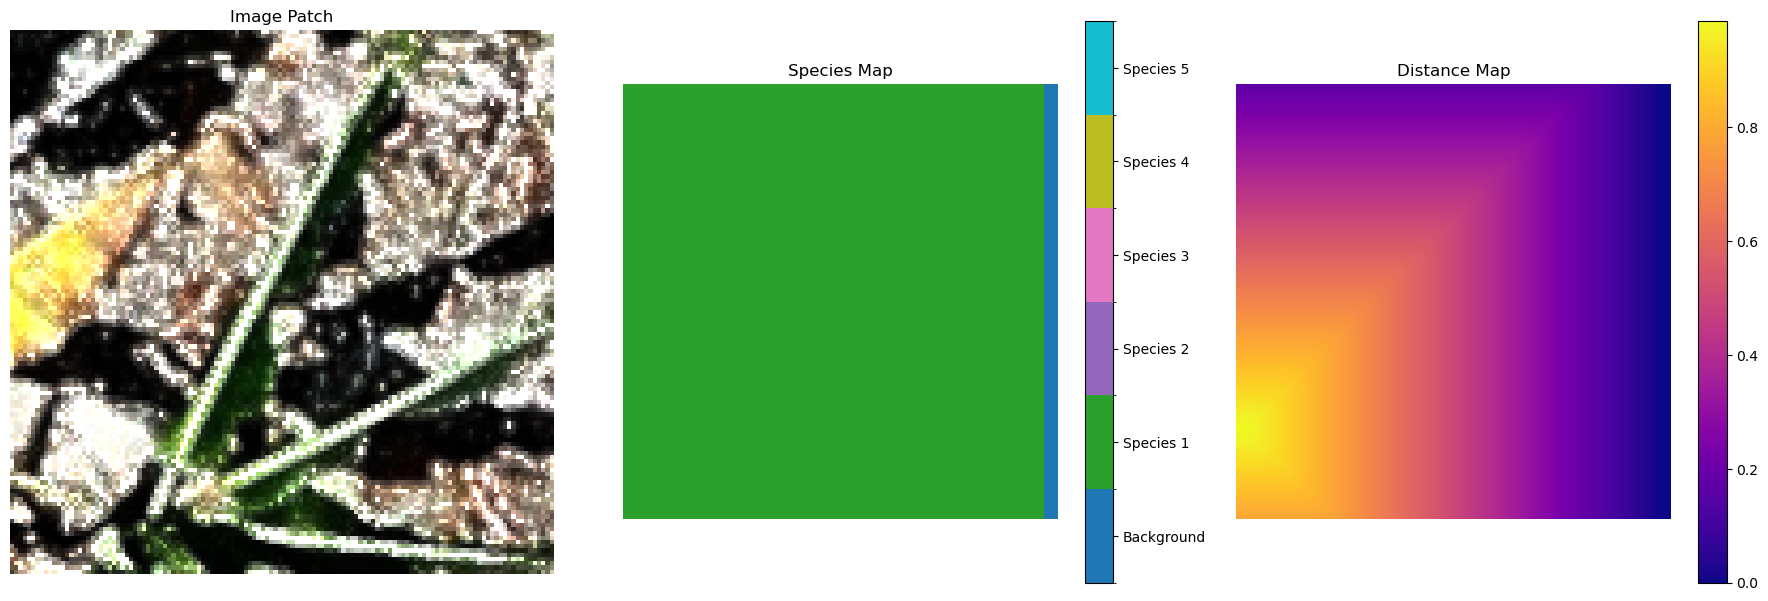

got here


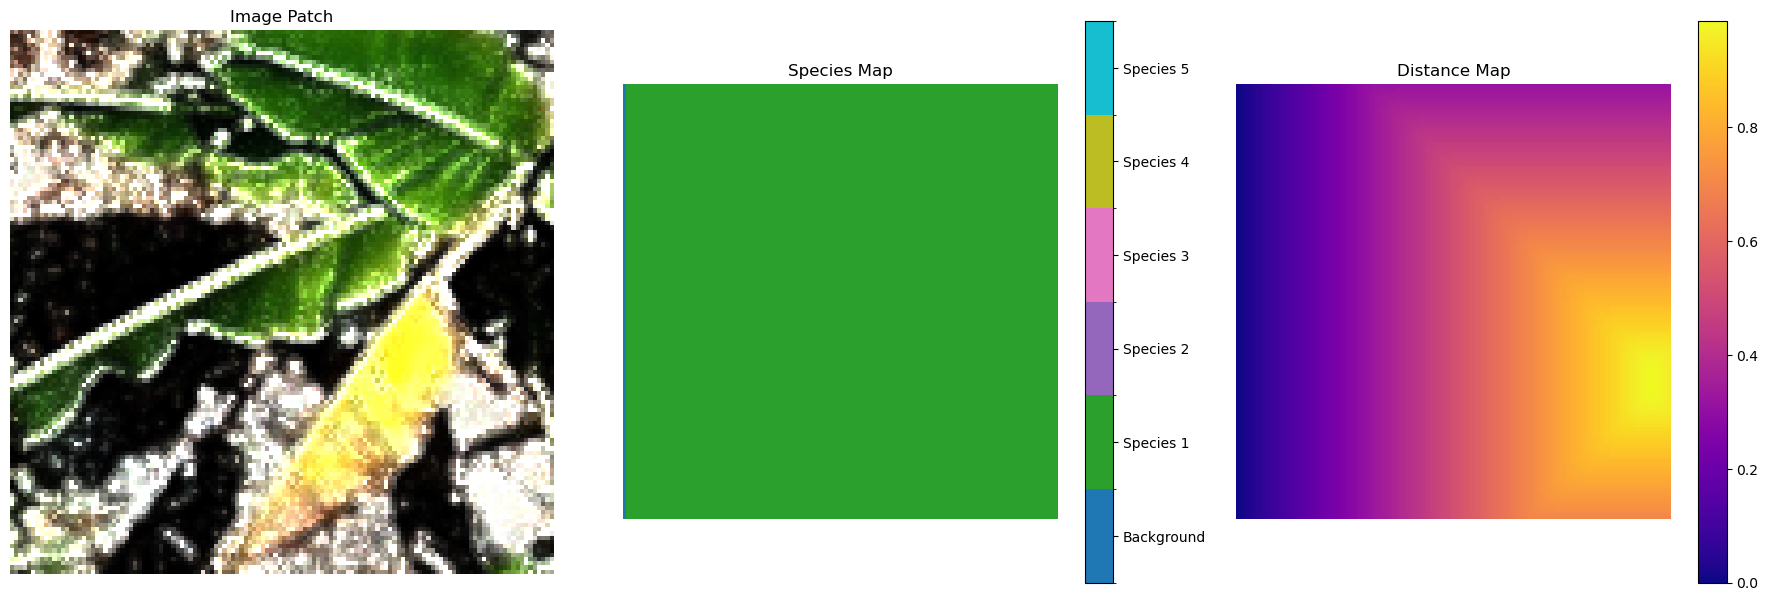

got here


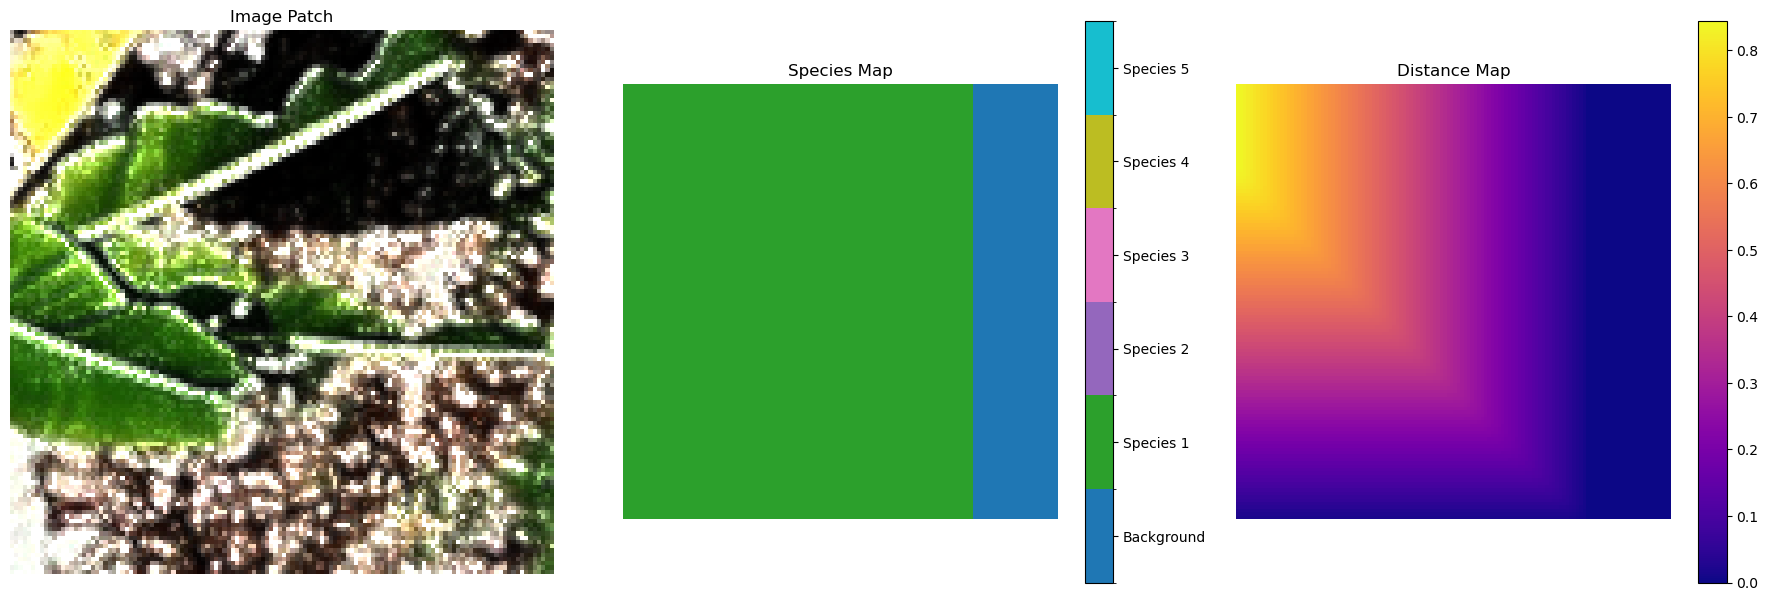

got here


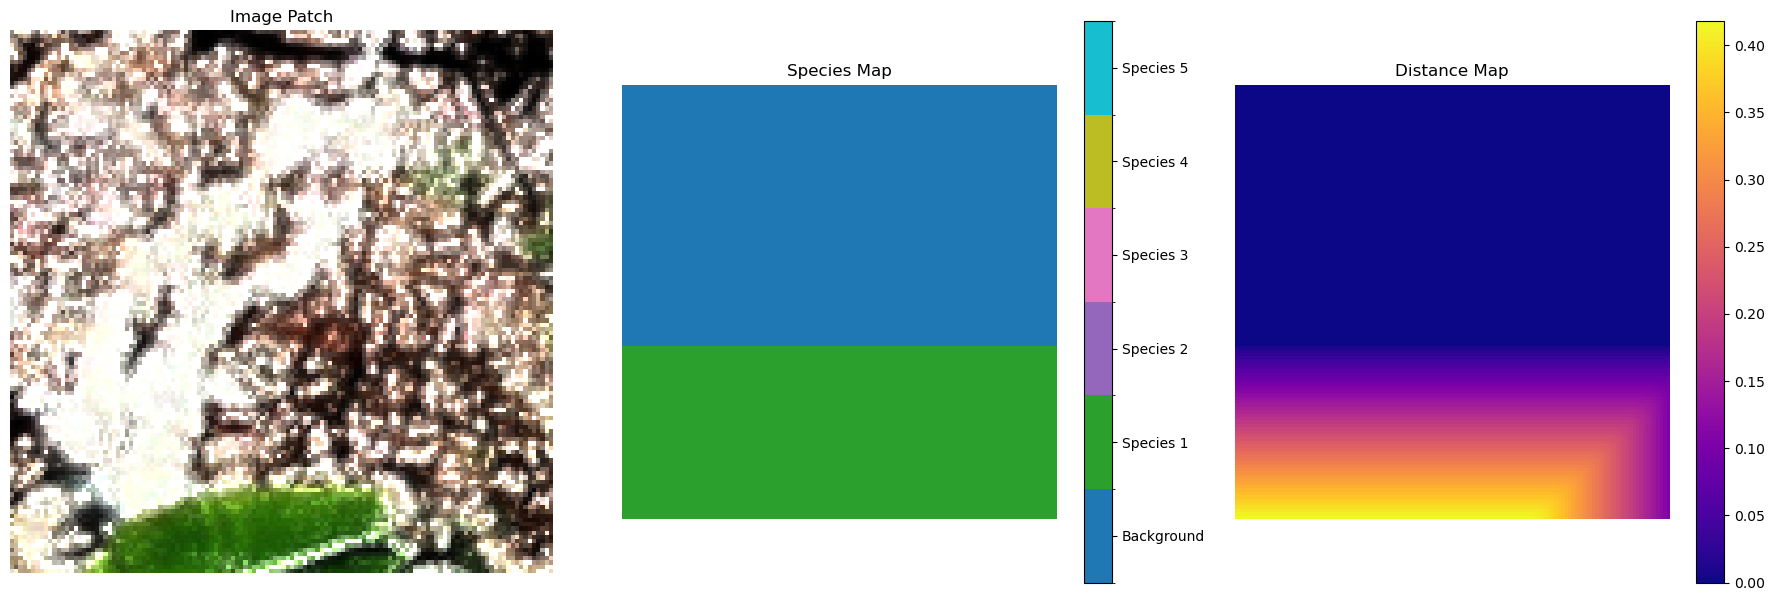

got here


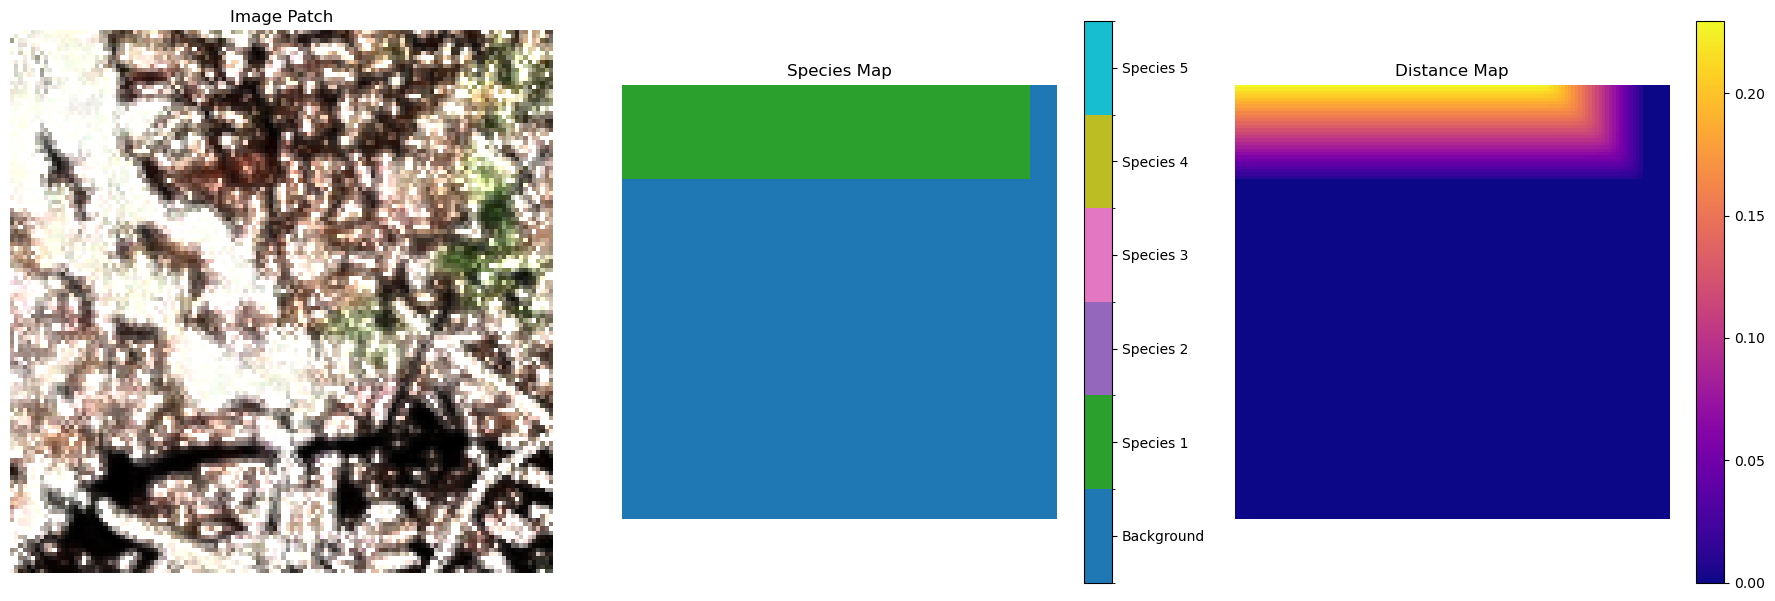

got here


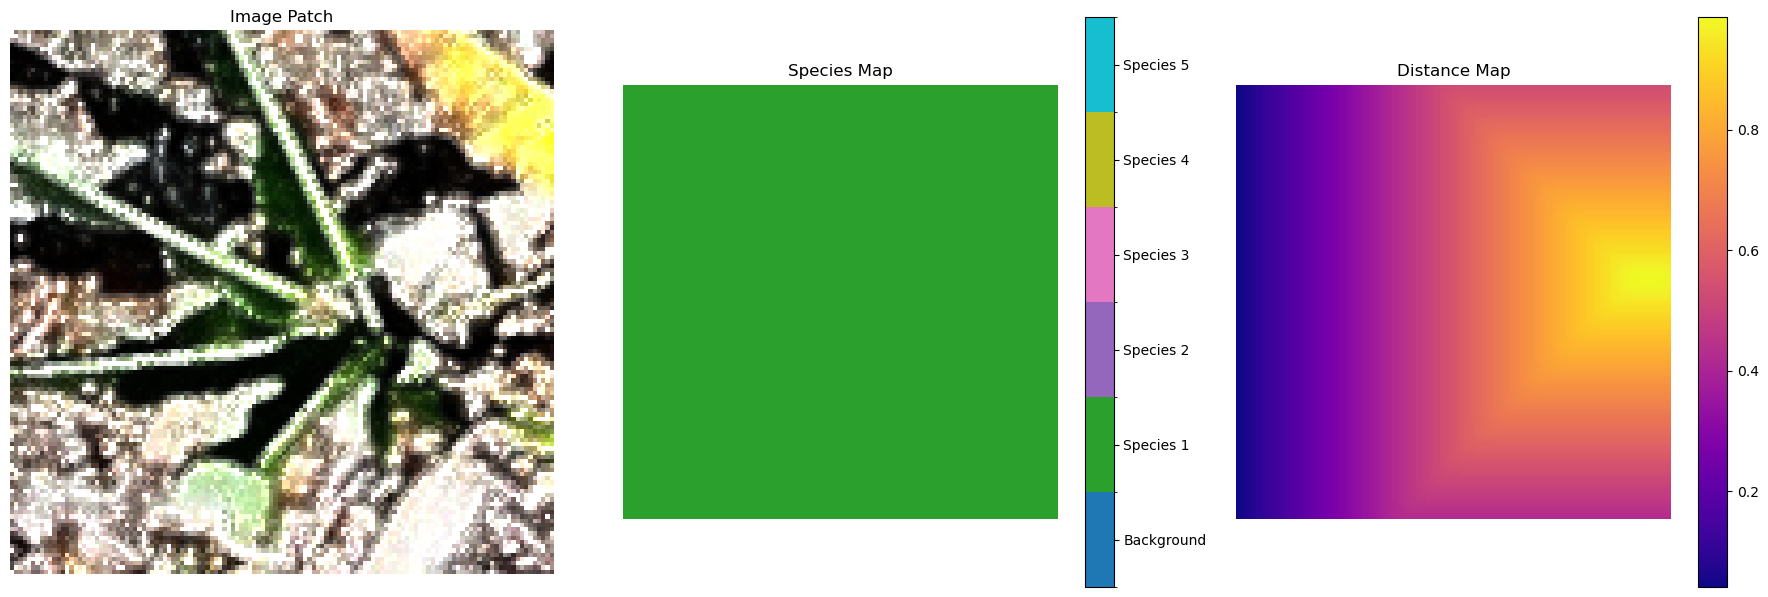

got here


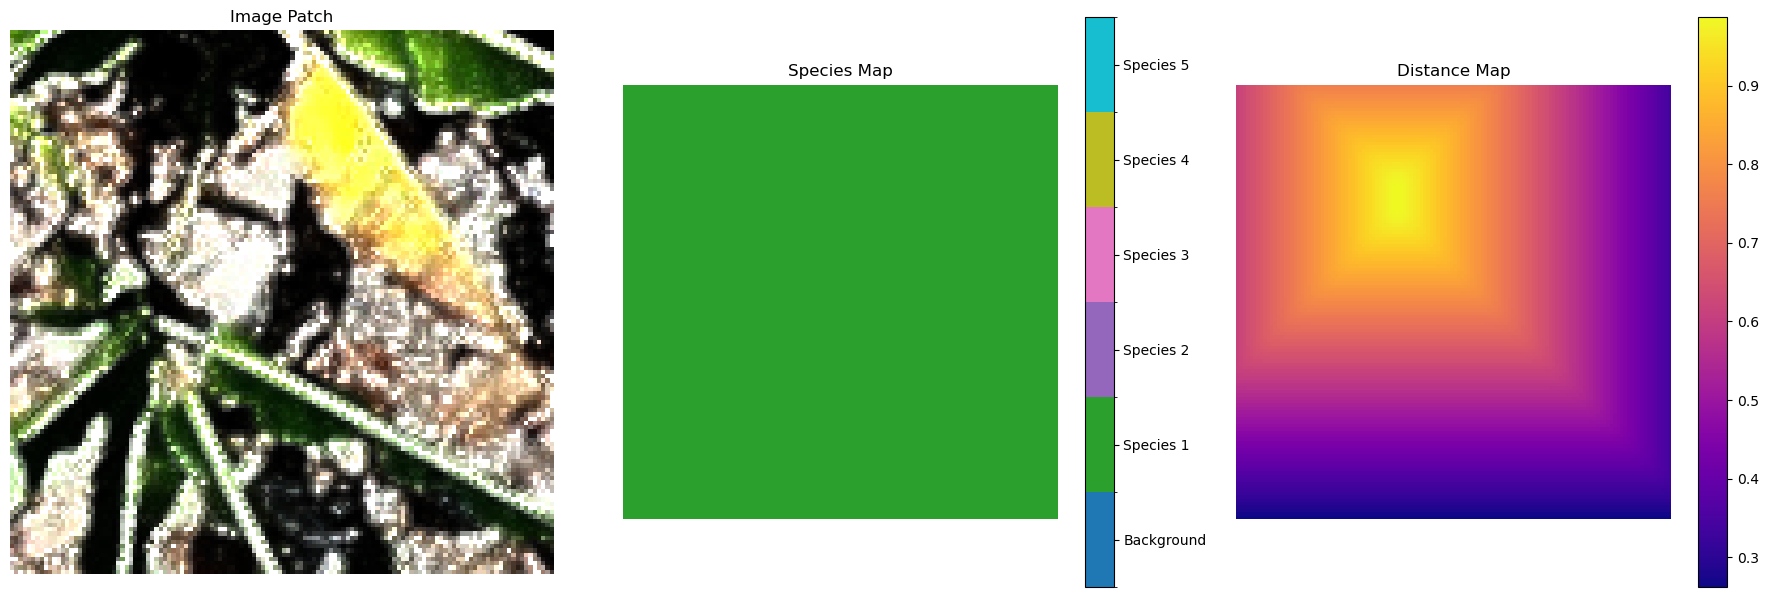

got here


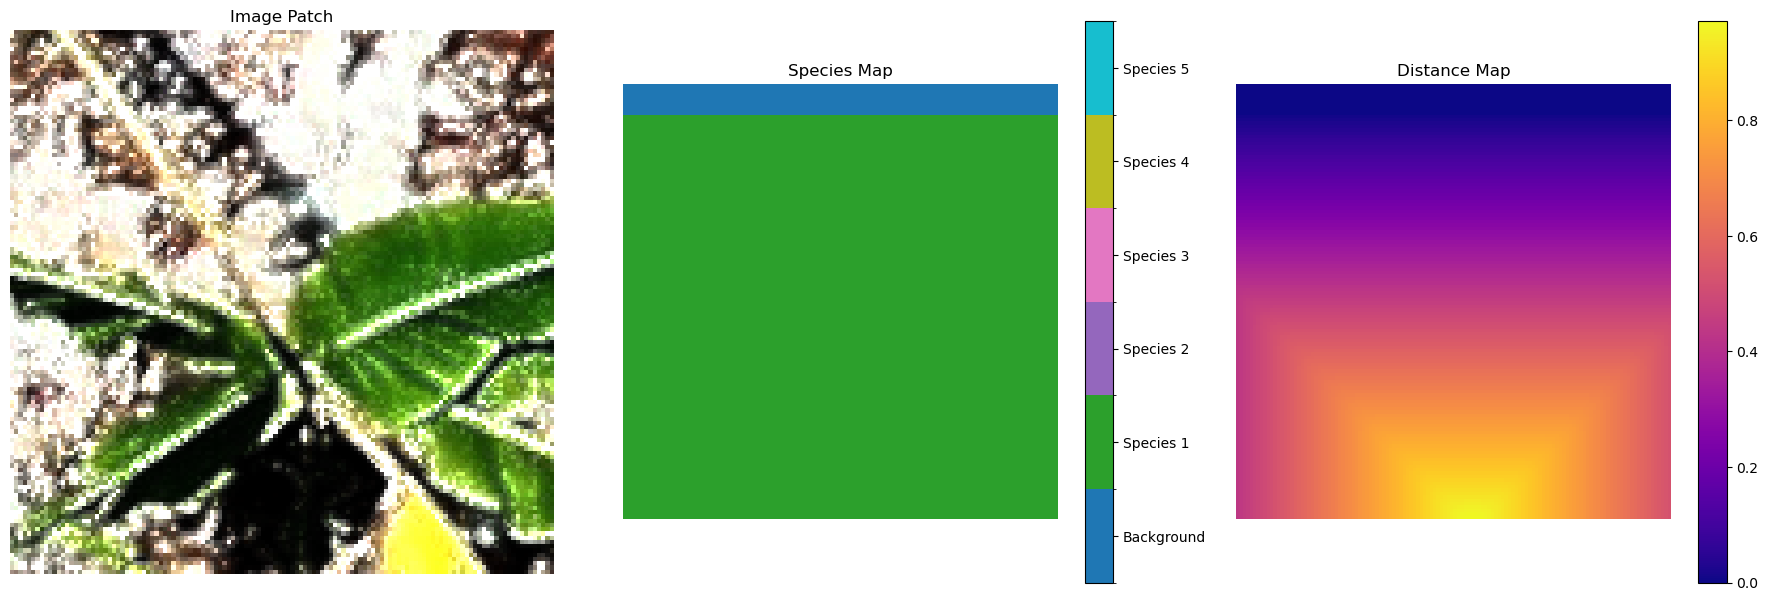

got here


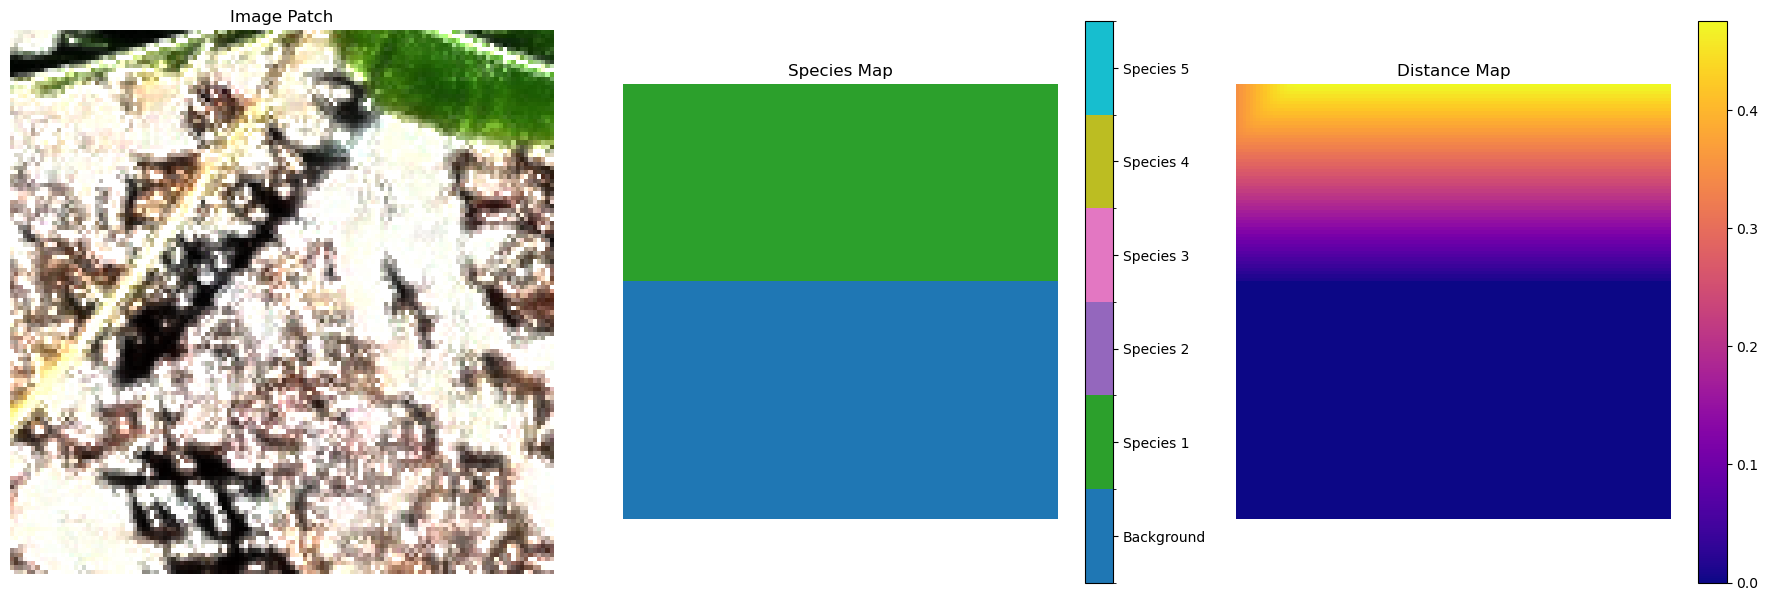

got here


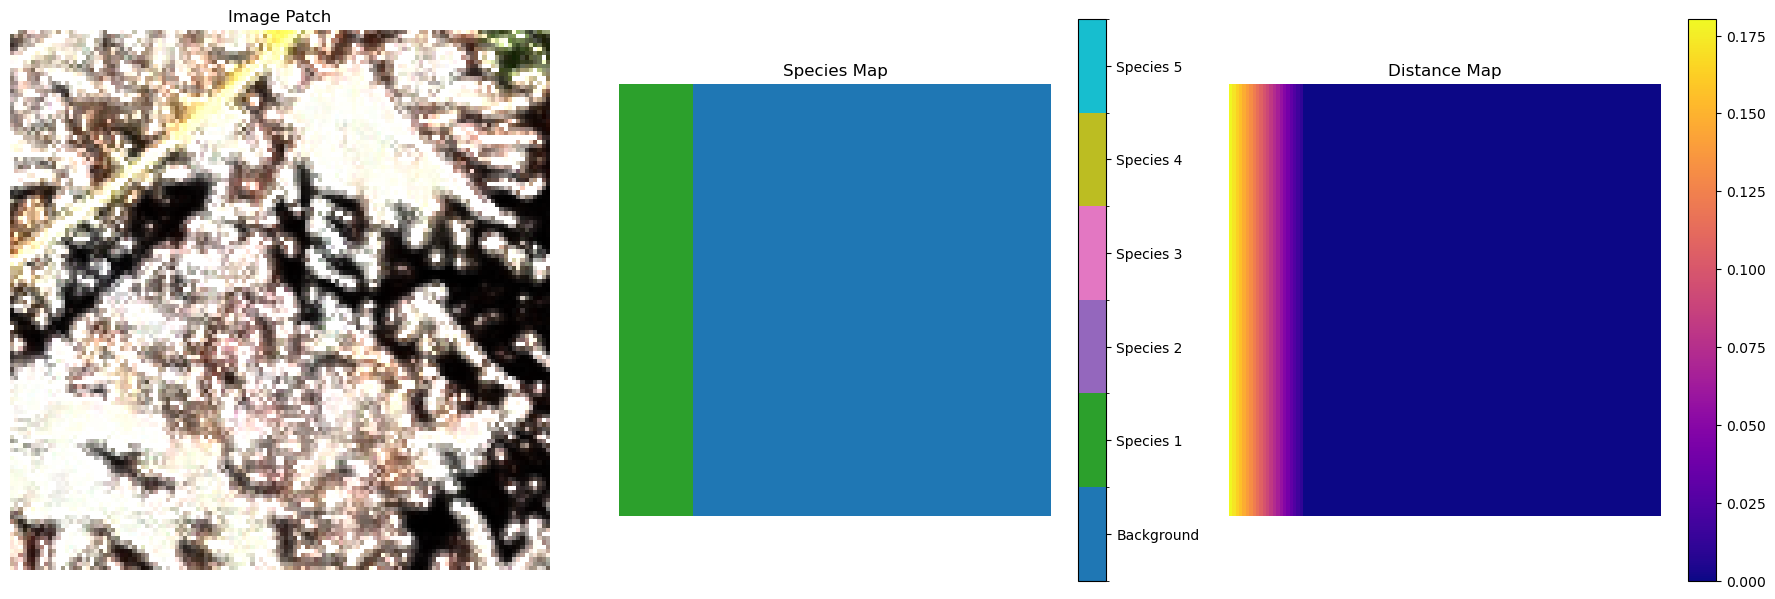

got here


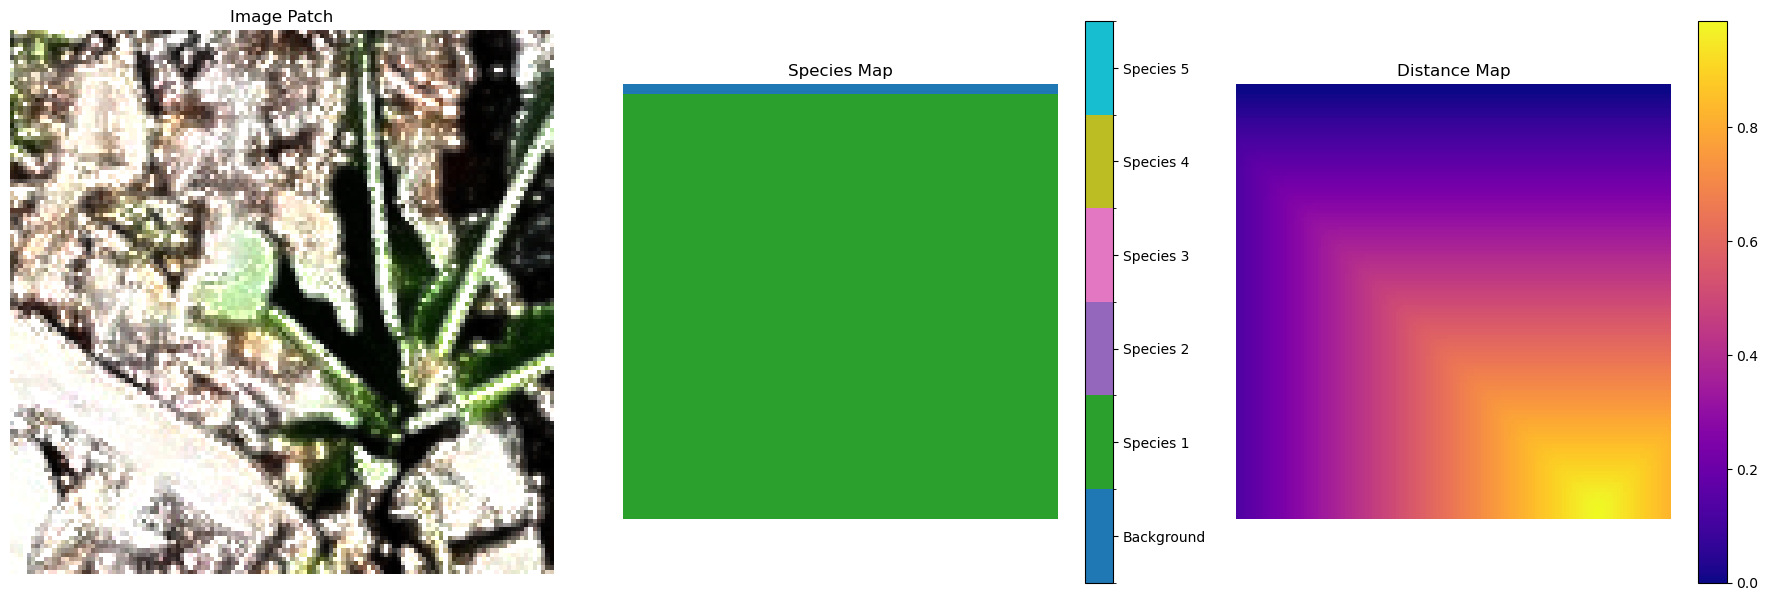

got here


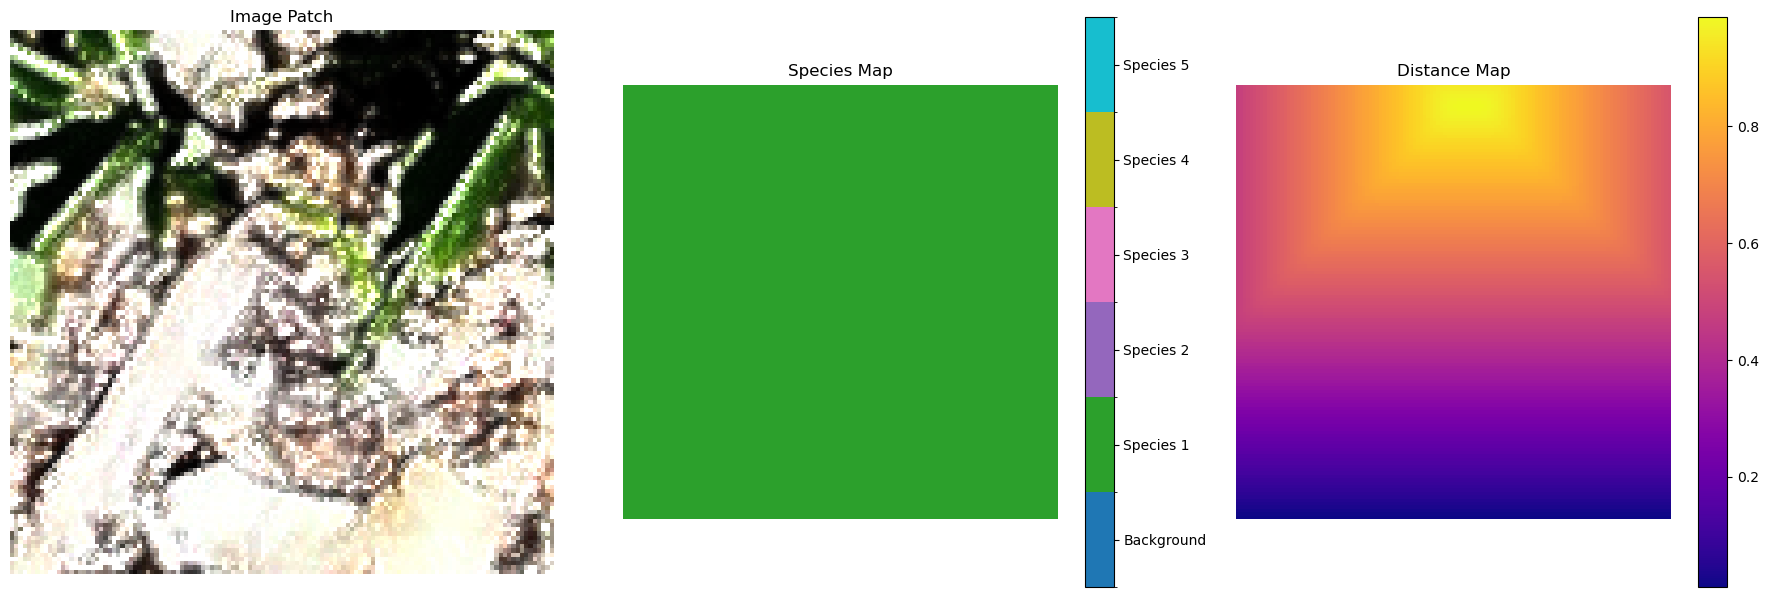

got here


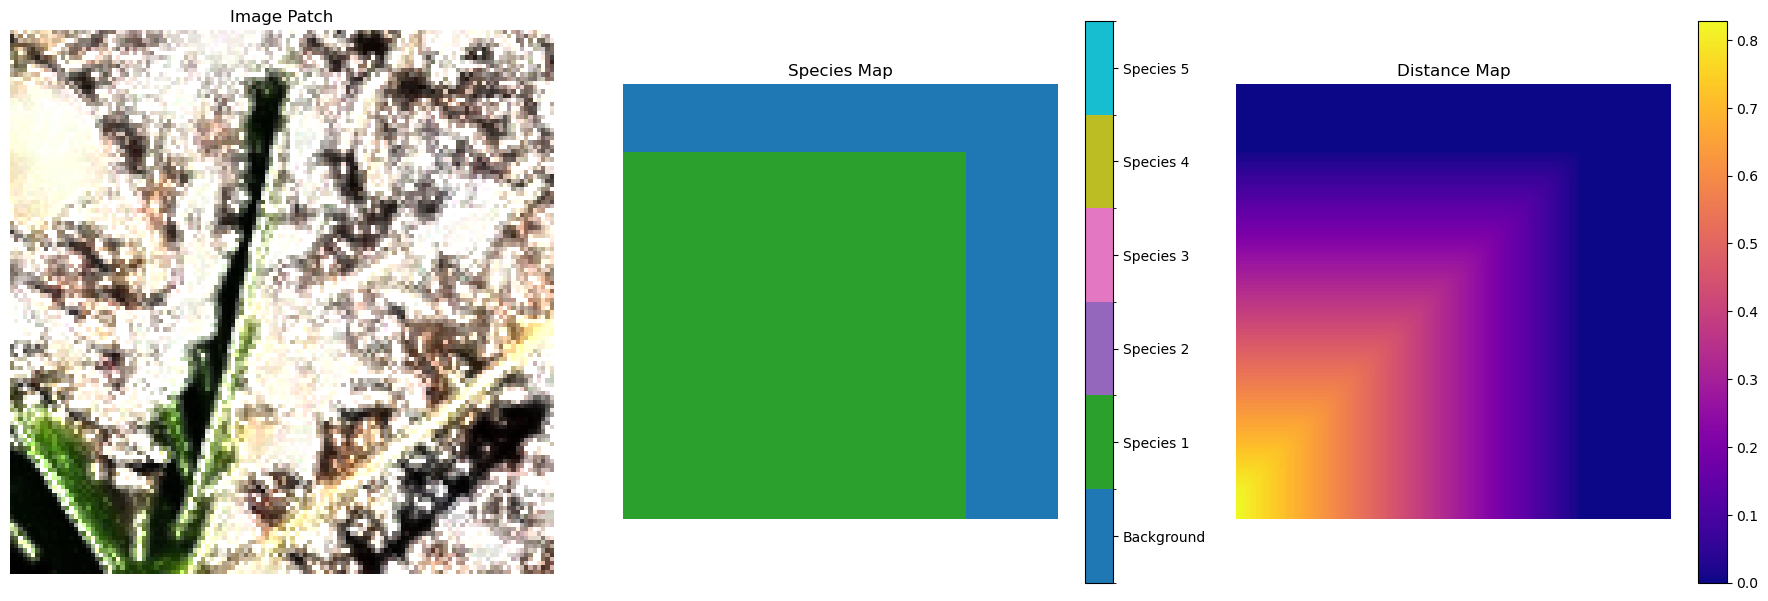

got here


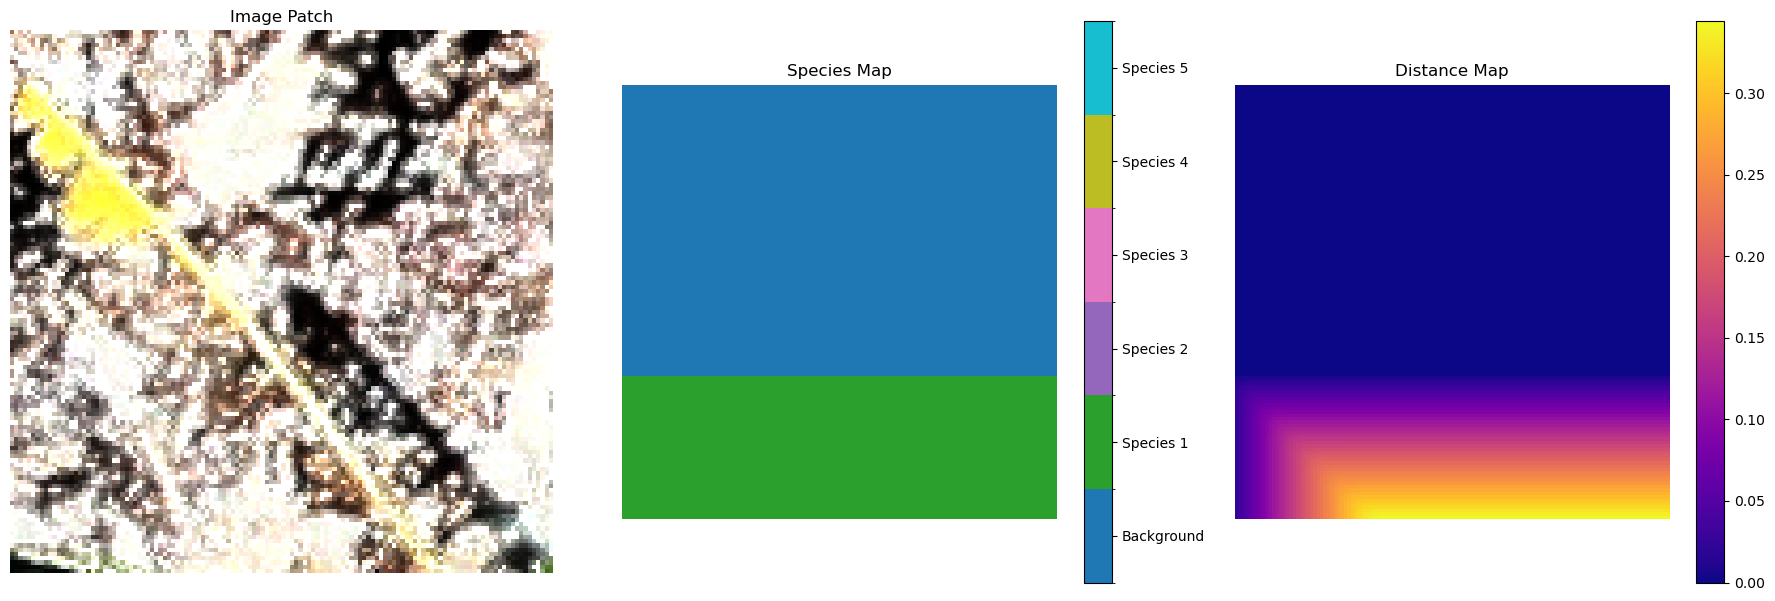

got here


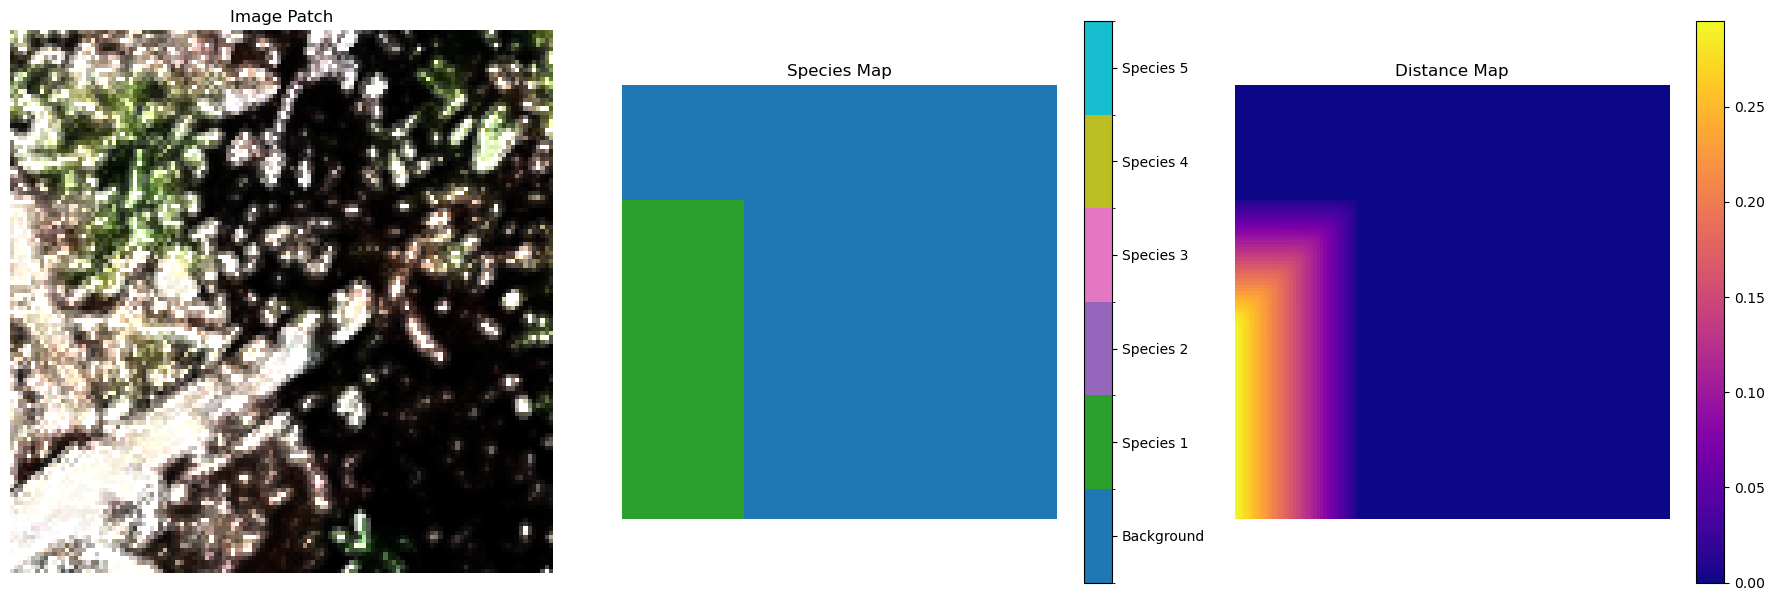

got here


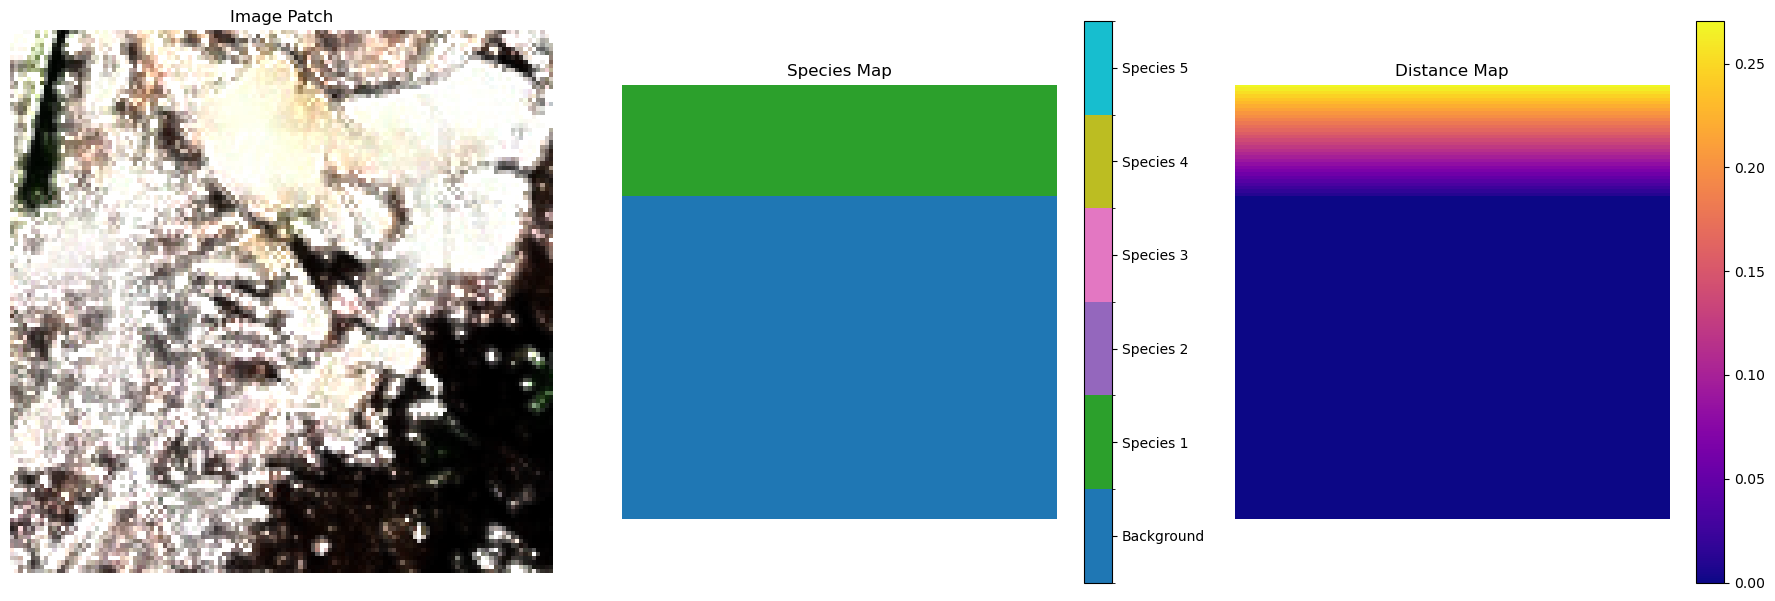

got here


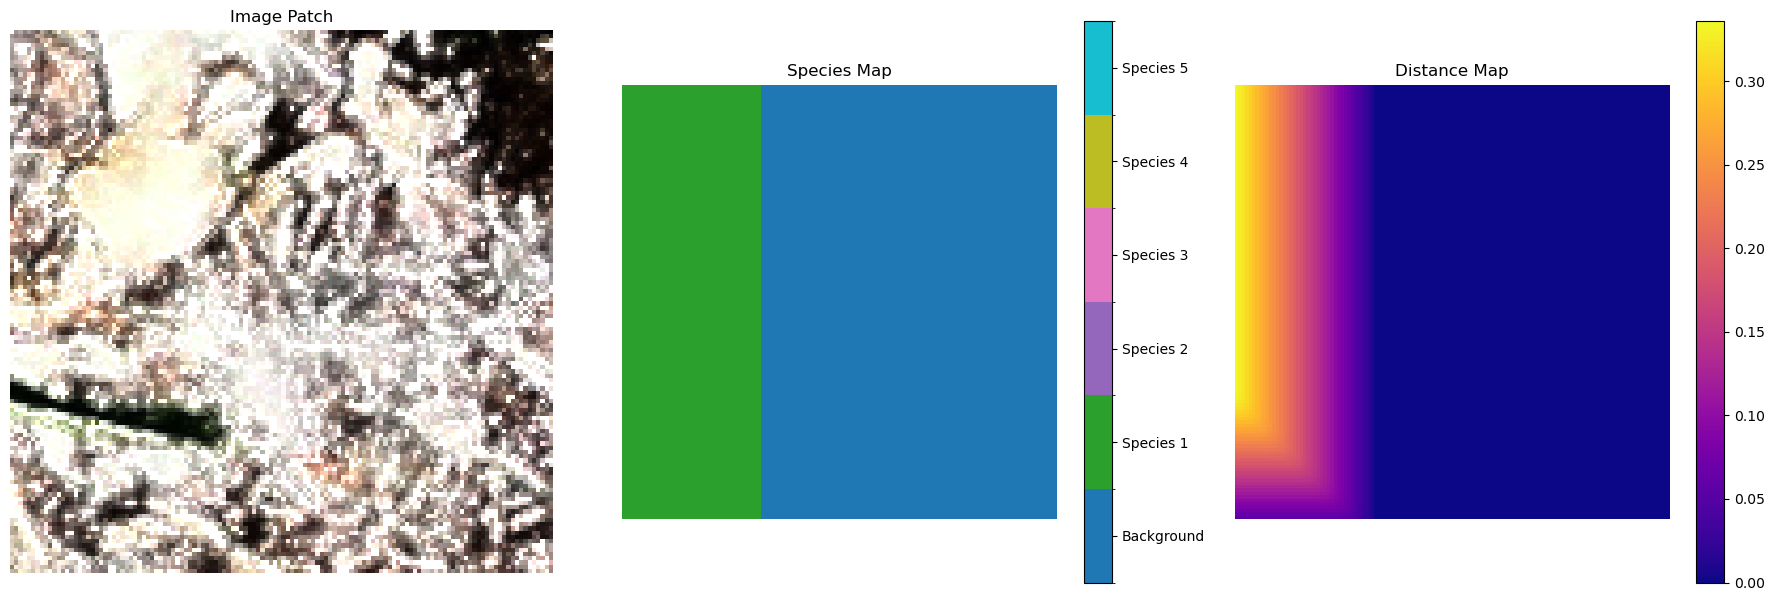

got here


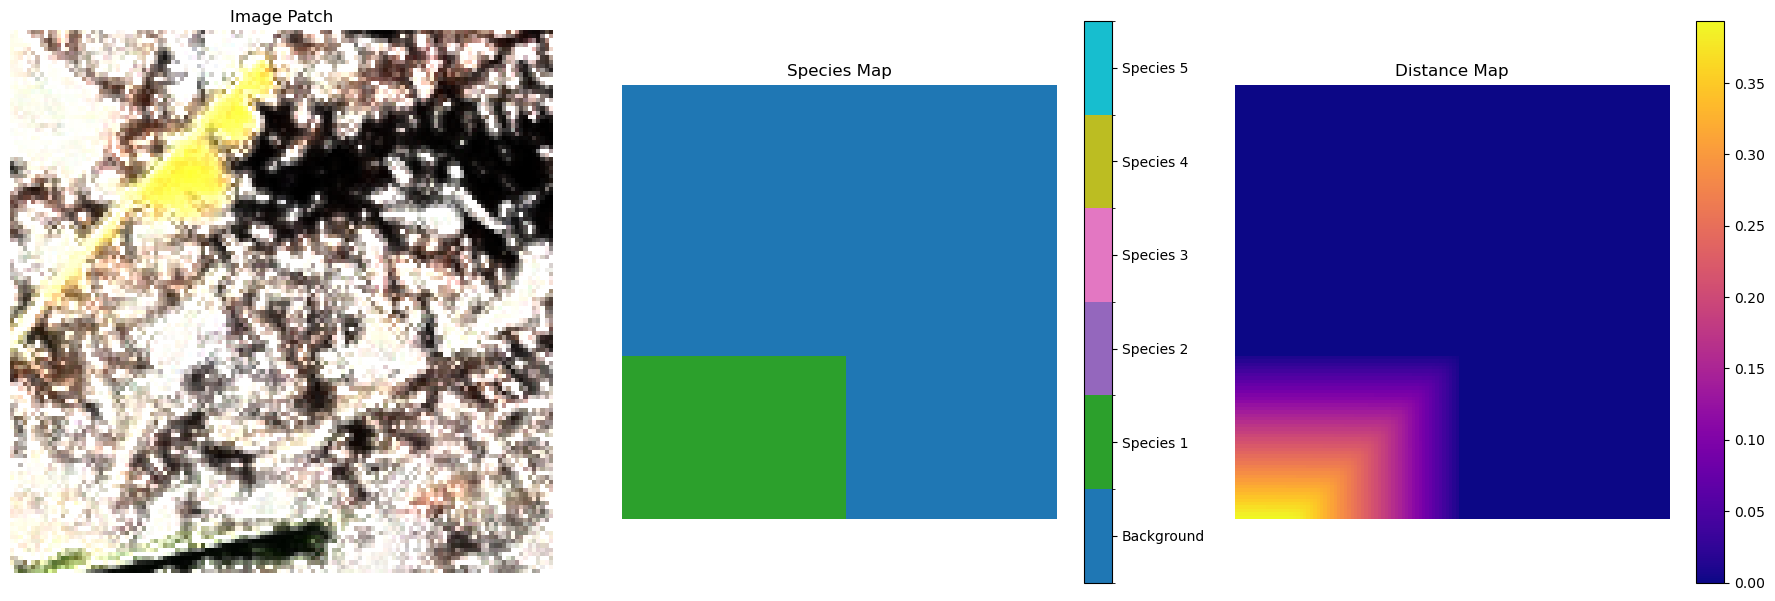

got here


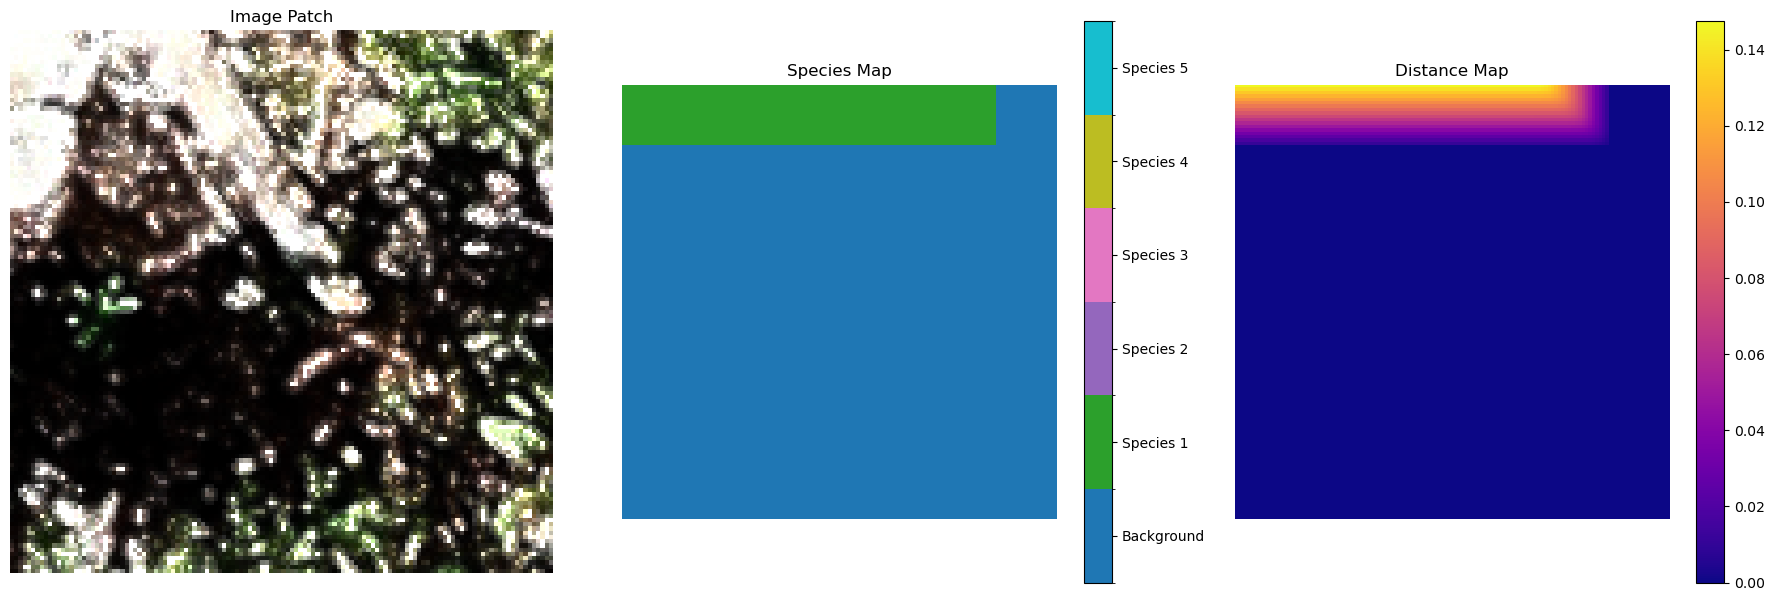

got here


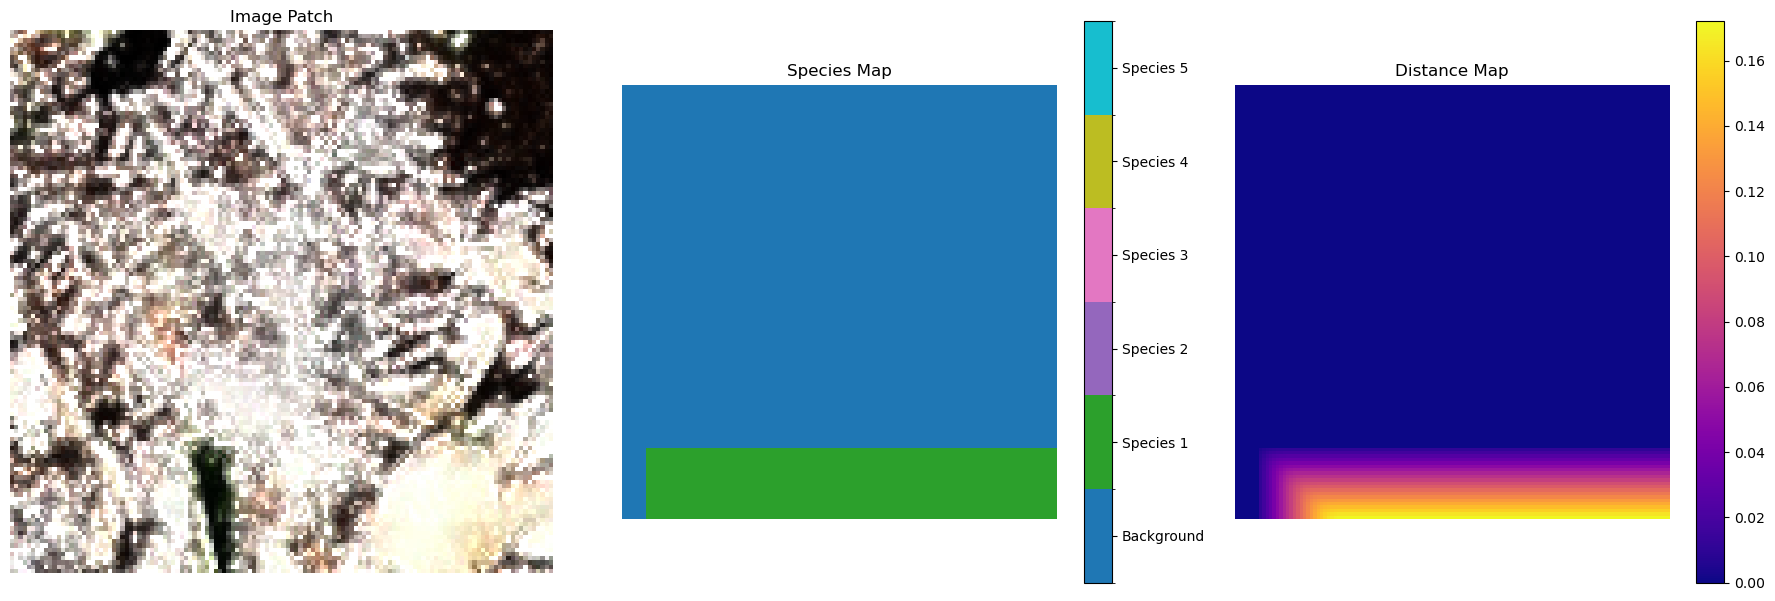

In [41]:
# Print the total number of entries in the dataset
print(f"Total entries in dataset: {len(dataset)}")

# Create an iterator from the dataset
data_iter = iter(dataset)

# Initialize the counter
count = 0

# Determine the maximum number of iterations
max_iterations = min(20, len(dataset))

# Process only the first few entries up to the maximum available
while count < max_iterations:
    try:
        print("got here")
        # Get the next batch from the dataset
        img_patch, species_patch, distance_patch = next(data_iter)
        
        patch_visualization(img_patch, species_patch, distance_patch)
        
        # Increment the counter
        count += 1
    except StopIteration:
        # Handle case where fewer items are available than expected
        print("Reached the end of the dataset")
        break


## Testing Data Loaded Correctly 

In [42]:
val_dataset = amu.TreeCrownDataset(dataframe=val_df_small, root_dir=root_dir, transform=transform)

In [43]:
train_loader = DataLoader(dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

measuring how long it takes to load a training batch

In [44]:
start_time = time.time()

data_iter = iter(train_loader)
images, species, distance = next(data_iter)

end_time = time.time()
print(f"Time to process one batch: {end_time - start_time} seconds")

Time to process one batch: 1.3710801601409912 seconds


And a val batch

In [45]:
start_time = time.time()

data_iter = iter(val_loader)
images, species, distance = next(data_iter)

end_time = time.time()
print(f"Time to process one batch: {end_time - start_time} seconds")

Time to process one batch: 1.0109448432922363 seconds


In [46]:
from matplotlib.colors import ListedColormap, BoundaryNorm
species_values = [0.0, 1, 2, 3, 4, 5]
species_colors = ['purple', 'red', 'blue', 'green', 'yellow', 'orange']
species_names = ["Background", "Musacea", "Guaba", "Cacao", "Mango", "Otra Variedad"]
cmap = ListedColormap(species_colors)
norm = BoundaryNorm(species_values + [species_values[-1] + 0.001], cmap.N)

In [47]:
def show_images_with_legend(images, nrow=2, ncol=4, title=None, cmap=None, norm=None, legend_patches=None):
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 12))
    if title:
        fig.suptitle(title, fontsize=16)
        
    for i, img in enumerate(images):
        if i >= nrow * ncol:
            break
        ax = axes[i // ncol, i % ncol]
        
        # Convert img to numpy array if it's a tensor
        if isinstance(img, torch.Tensor):
            img = img.numpy()
        
        # Remove any singleton dimensions and handle batch dimension
        img = np.squeeze(img)
        
        # If img still has 3 dimensions and first dimension is batch size, select the first in the batch
        if img.ndim == 3 and img.shape[0] > 1:
            img = img[0]
        
        unique, counts = np.unique(img, return_counts=True)
        print(f"Image {i} unique values and counts: {dict(zip(unique, counts))}")
        
        # Ensure img has 2 dimensions for cmap and norm
        ax.imshow(img, cmap=cmap, norm=norm)
        ax.axis('off')

    # Add the legend to the figure outside the subplots
    if legend_patches:
        fig.legend(handles=legend_patches, loc='upper right', fontsize='small')
        
    plt.tight_layout()
    plt.show()

### Making sure there are distinct classes

In [48]:
val_class_distribution = amu.analyze_class_distribution(val_loader)
print(val_class_distribution)

{0: 2233048, 1: 3190999, 2: 681319, 3: 788575, 4: 91444, 5: 567639}


### Testing: visualizing one tree for confirmation of proper tree and distance maps

In [49]:
data_iter = iter(test_loader)
images, species_maps, dist_maps = next(data_iter)

NameError: name 'test_loader' is not defined

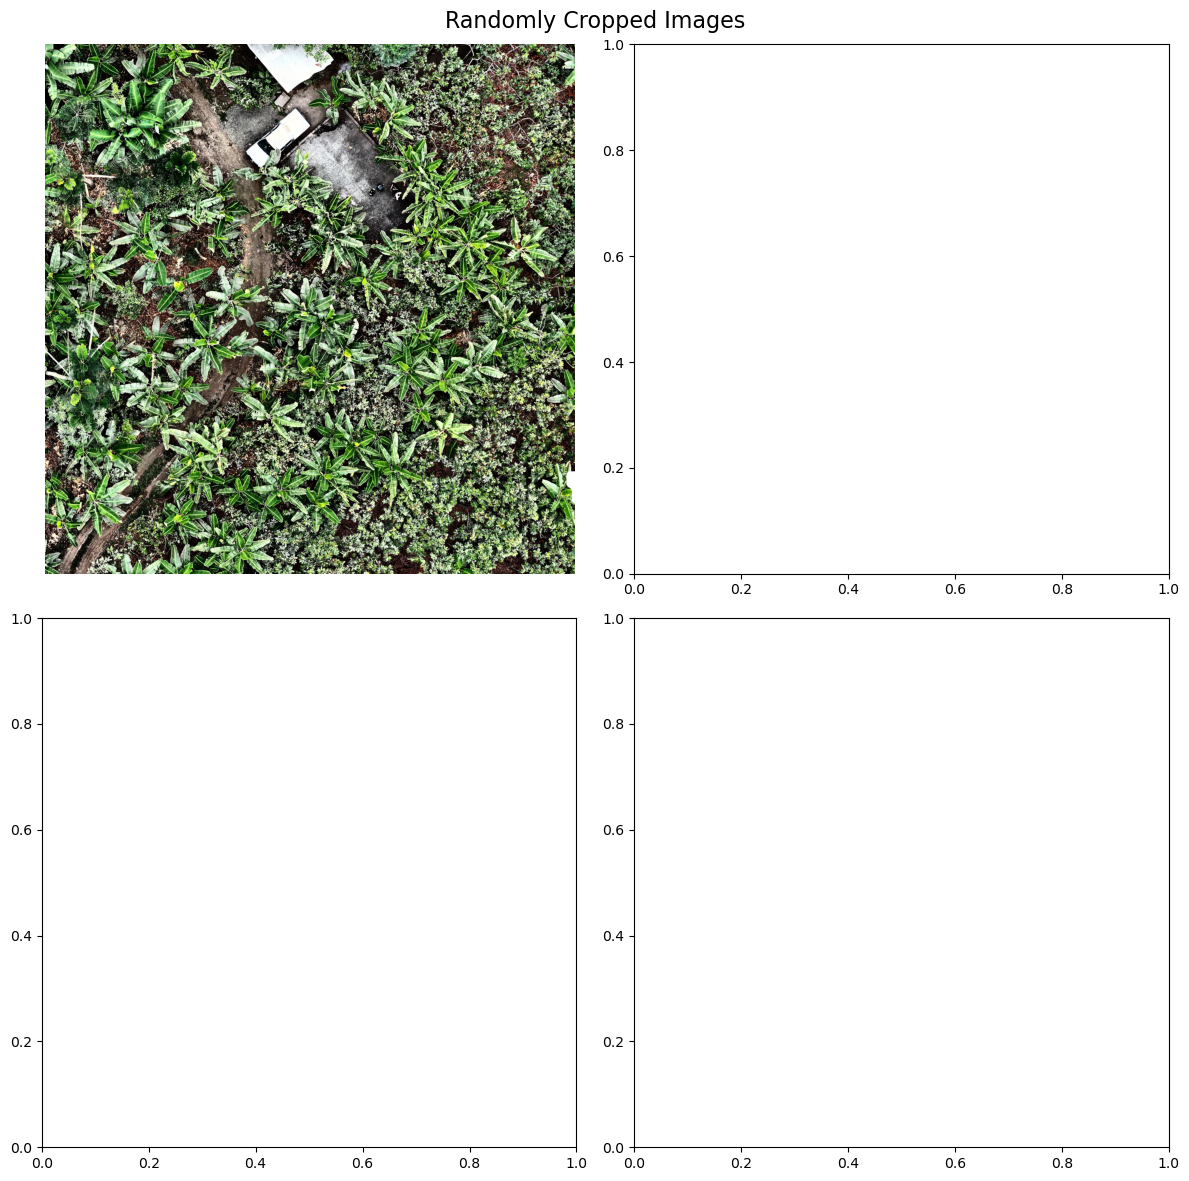

Image 0 unique values and counts: {0: 12816318, 1: 2078134, 2: 579192, 3: 197089, 4: 63909, 5: 265358}


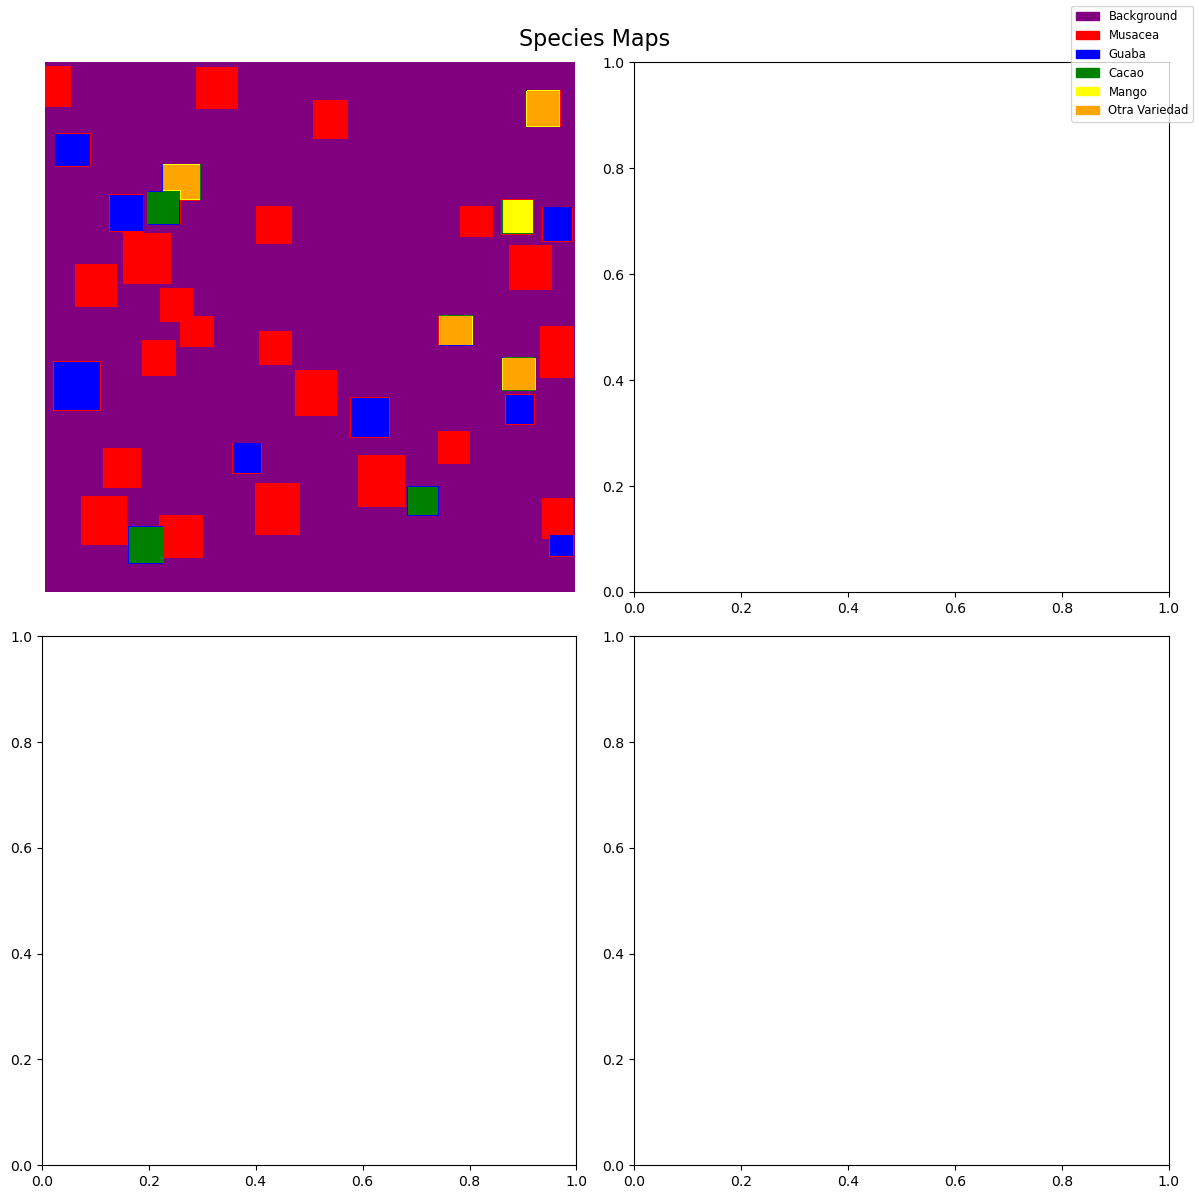

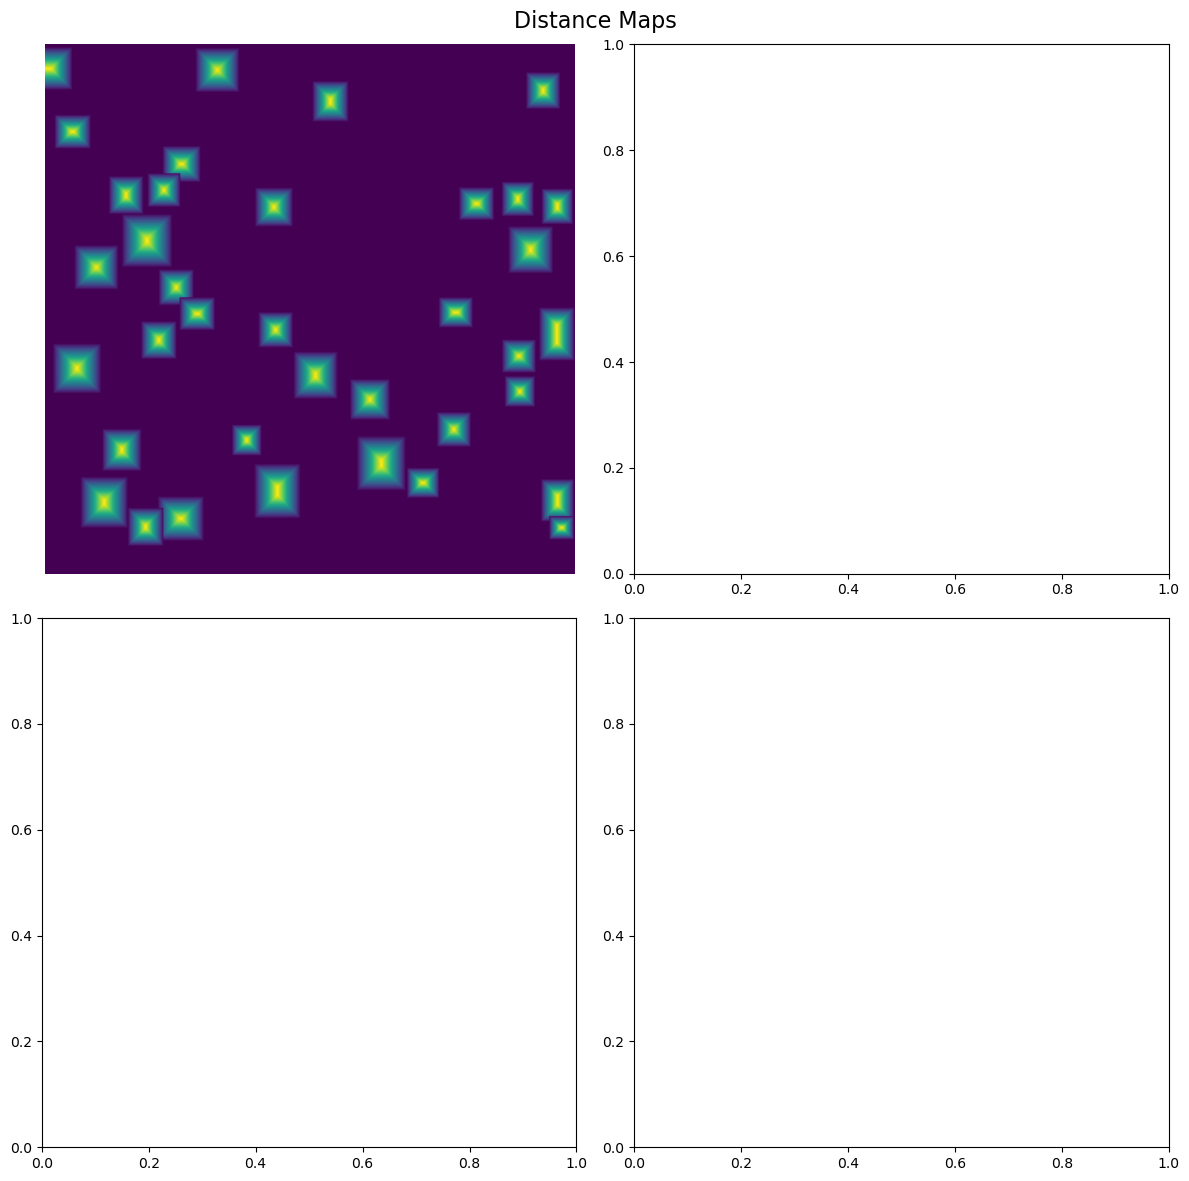

In [ ]:
# Will look weird because I only have one image to show
num_images_to_show = 1
indices = random.sample(range(images.size(0)), num_images_to_show)

selected_images = [images[i] for i in indices]
selected_species = [species_maps[i] for i in indices]
selected_distance = [dist_maps[i] for i in indices]

legend_patches = [Patch(color=species_colors[i], label=species_names[i]) for i in range(len(species_values))]

# Show the images
mu.show_images(selected_images, nrow=2, ncol=2, title="Randomly Cropped Images")
show_images_with_legend(selected_species, nrow=2, ncol=2, title="Species Maps", cmap=cmap, norm=norm, legend_patches=legend_patches)
mu.show_images(selected_distance, nrow=2, ncol=2, title="Distance Maps")

______

# Running the Model

## Setting Device

In [50]:
device = amu.set_device("cuda")

No GPU available! Running on CPU


## Training the Model 

In [51]:
model = amu.SEDDModel(num_classes=6).to(device)
semantic_loss_fn = amu.PartiallyWeightedCategoricalFocalLoss(alpha=0.25).to(device)
distance_loss_fn = nn.MSELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 2

<Figure size 640x480 with 0 Axes>

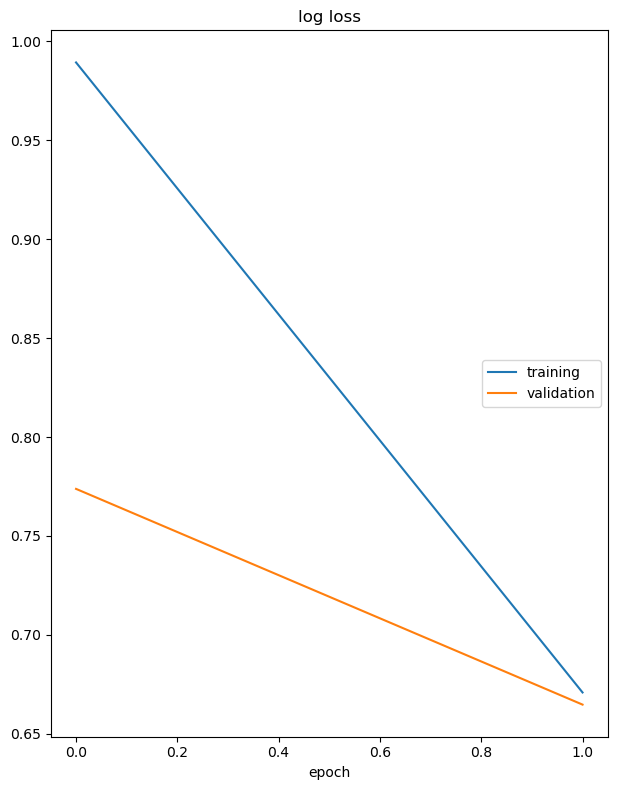

log loss
	training         	 (min:    0.671, max:    0.989, cur:    0.671)
	validation       	 (min:    0.665, max:    0.774, cur:    0.665)
Epoch [2/2], Train Loss: 0.6708, Validation Loss: 0.6647


<Figure size 640x480 with 0 Axes>

In [53]:
liveplot = PlotLosses()

start = time.time()

for epoch in range(num_epochs):
    logs = {}
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # Fit the model and calculate training loss
    train_loss = amu.fit(model, train_loader, optimizer, semantic_loss_fn, distance_loss_fn, device)
    print(f'Fitting took {time.time()-start:.2f} seconds')

    # Validate the model and calculate validation loss
    val_loss = amu.validate(model, val_loader, semantic_loss_fn, distance_loss_fn, device)
    print(f'Validation took {time.time()-start:.2f} seconds')
    
    # Log the losses
    logs['log loss'] = train_loss
    logs['val_log loss'] = val_loss

    # Update and draw live plot
    liveplot.update(logs)
    liveplot.draw()

    # Step the learning rate scheduler
    scheduler.step()

    # Save the plot to a file
    plt.savefig(f'live_plot_epoch_{epoch+1}.png')

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), "ASPPModel_small.pth")

## Code to Evaluate

## Testing the in-notebook model

In [54]:
model_notebook = amu.SEDDModel(6)
model_notebook.load_state_dict(torch.load('ASPPModel_small.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [55]:
model_notebook.eval()
model_notebook.to(device)

SEDDModel(
  (encoder): ResNet9Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu): ELU(alpha=1.0, inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu): ELU(alpha=1.0, inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu

## Testing what predicitons look like

This is because I am not seeing a purple background with the test images, so I want to make sure it is working here. 

In [ ]:
model_notebook = mu.SEDDModel(6)
model_notebook.load_state_dict(torch.load('models/ASPPModel_small.pth',map_location=torch.device('cpu')))

/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [56]:
# Select a batch from the validation DataLoader
data_iter = iter(val_loader)
images, species_maps, dist_maps = next(data_iter)

# Check the shape of the images tensor
print(f"Original shape of images: {images.shape}")

Original shape of images: torch.Size([4, 3, 128, 128])


In [57]:
# If the shape is not [batch_size, channels, height, width], reshape it
if len(images.shape) == 5:
    images = images.view(-1, images.size(2), images.size(3), images.size(4))

# Check the shape after reshaping
print(f"Reshaped shape of images: {images.shape}")

# Move images to the device
images = images.to(device)

# Set the model to evaluation mode
model_notebook.eval()

Reshaped shape of images: torch.Size([4, 3, 128, 128])


SEDDModel(
  (encoder): ResNet9Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu): ELU(alpha=1.0, inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu): ELU(alpha=1.0, inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu

In [58]:
# Perform inference to get the predicted distance maps
with torch.no_grad():
    semantic_pred, distance_pred = model_notebook(images)

# Move the predictions to the CPU and convert to NumPy arrays
predicted_distance_maps = distance_pred.cpu().numpy()
predicted_semantic_maps = semantic_pred.cpu().numpy()

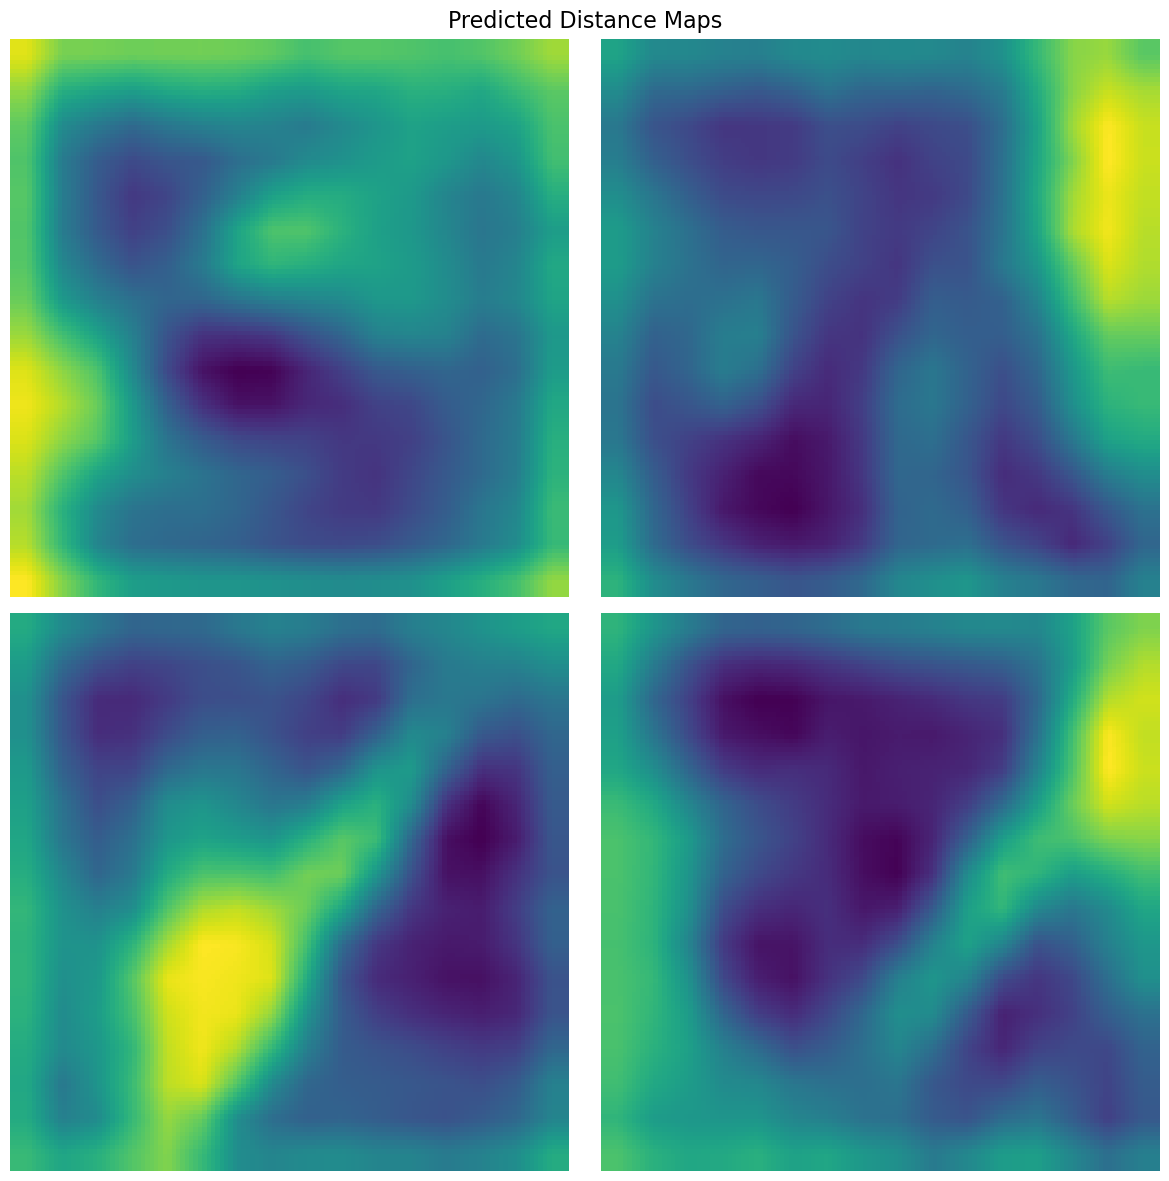

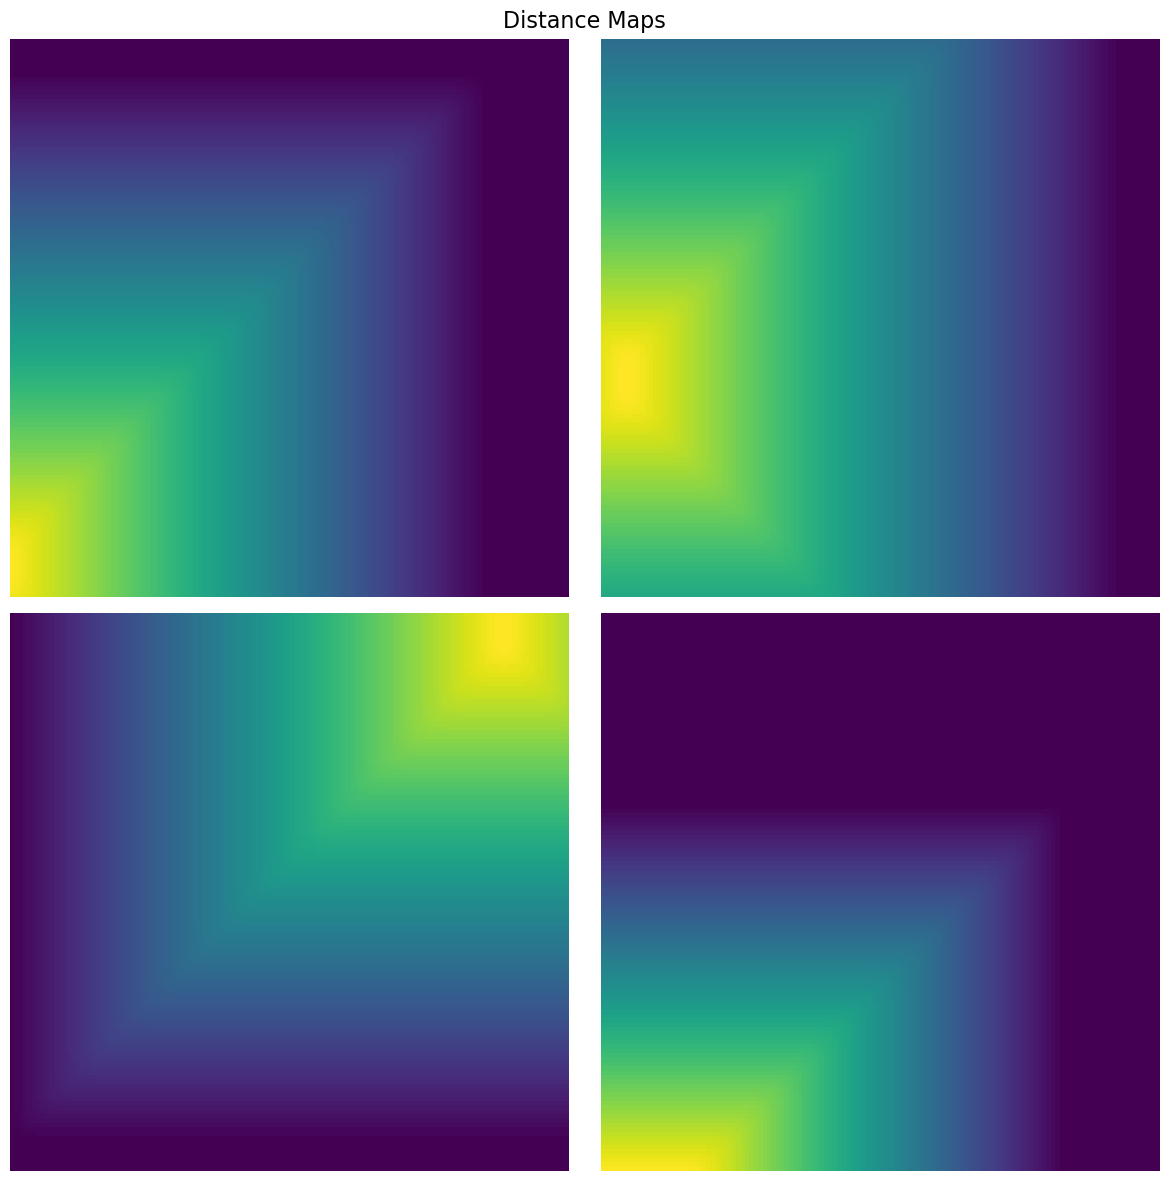

In [59]:
# Visualize the predicted distance maps

#convert to tensor
distance_tensors = []
for image in predicted_distance_maps:
    image = TF.to_tensor(image).squeeze()
    distance_tensors.append(image)
mu.show_images(distance_tensors, nrow=2, ncol=2, title="Predicted Distance Maps")

mu.show_images(dist_maps, nrow=2, ncol=2, title="Distance Maps")

## Testing Test Images; Sliding Window

In [ ]:
# Evaluate model using sliding window inference on full-size images
patch_size = (224, 224)  # Patch size
stride = (112, 112)  # 50% overlap

In [ ]:
accuracy, precision, recall, f1, mse, all_original_images, all_species_maps, all_distance_maps, all_probability_maps = mu.full_evaluation(model_notebook, test_loader, patch_size, stride, device)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test Distance Map MSE: {mse:.4f}')

KeyboardInterrupt: 